# Import Required Libraries

In [258]:
import numpy as np
import pandas as pd
import datetime
from collections import Counter
import os
import pickle
import io
import time

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest

from IPython.display import Markdown

def bold(string):
    display(Markdown("**" + string + "**"))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load Data

In [164]:
df_ = pd.read_csv('/mnt/hdd/Datasets/game_data_all.csv', index_col=0)
df = df_.copy()
df.head()

game           link     release  peak_players  \
0                       Pizza Tower  /app/2231450/  2023-01-26          4529   
1                   Resident Evil 4  /app/2050650/  2023-03-24        168191   
2  The Murder of Sonic the Hedgehog  /app/2324650/  2023-03-31         15543   
3                Pineapple on pizza  /app/2263010/  2023-03-28          1415   
4                        Hi-Fi RUSH  /app/1817230/  2023-01-25          6132   

   positive_reviews  negative_reviews  total_reviews  rating primary_genre  \
0             19807               227          20034   96.39    Action (1)   
1             61752              1616          63368   95.75    Action (1)   
2             12643               213          12856   95.54    Casual (4)   
3             11717               209          11926   95.39    Indie (23)   
4             14152               324          14476   95.09    Action (1)   

                                                 store_genres  \
0                                      Action (1), Indie (23)   
1                                  Action (1), Adventure (25)   
2  Casual (4), Free to Play (37), Indie (23), Simulation (28)   
3                   Casual (4), Free to Play (37), Indie (23)   
4                                                  Action (1)   

            publisher        developer  \
0       Tour De Pizza    Tour De Pizza   
1     CAPCOM Co. Ltd.  CAPCOM Co. Ltd.   
2                SEGA             SEGA   
3        Majorariatto     Majorariatto   
4  Bethesda Softworks  Tango Gameworks   

                                                                                                                                                                                    detected_technologies  \
0                                                                                                                                                                              Engine.GameMaker; SDK.FMOD   
1                                                                                                                                                                  Engine.RE_Engine; SDK.AMD_GPU_Services   
2                                                                                                                                                                  Engine.Unity; SDK.UnityBurst; SDK.cURL   
3                                                                                                                                                                                  Engine.Unity; SDK.cURL   
4  Engine.Unreal; SDK.Intel_OID; SDK.Intel_XeSS; SDK.NVIDIA_APEX; SDK.NVIDIA_DLSS; SDK.NVIDIA_GeForce_Now; SDK.NVIDIA_Nsight_Aftermath; SDK.NVIDIA_PhysX; SDK.Vorbis; SDK.Wwise; SDK.XAudio2; SDK.iZotope   

  store_asset_mod_time  review_percentage players_right_now 24_hour_peak  \
0           2023-01-10              98.00             3,101        3,606   
1           2023-03-29              97.00            46,289       47,164   
2           2023-03-24              98.00               618          776   
3           2023-03-22              98.00               101          101   
4           2023-04-11              97.00               630          664   

   all_time_peak all_time_peak_date  
0           4529         2023-03-25  
1         168191         2023-03-25  
2          15543         2023-03-31  
3           1415         2023-03-28  
4           6132         2023-01-29

In [165]:
def df_stats(data):
    bold("**" + " SHAPE ".center(50, "#") + "**")
    print("ROWS: {}".format(data.shape[0]))
    print("COLUMNS: {}".format(data.shape[1]))
    bold("**" + " TYPES ".center(50, "#") + "**")
    print(data.dtypes)
    bold("**" + " MISSING VALUES ".center(50, "#") + "**")
    print(data.isnull().sum())
    bold("**" + " DUPLICATED VALUES ".center(50, "#") + "**")
    print("NUMBER OF DUPLICATED VALUES: {}".format(data.duplicated().sum()))
    bold("**" + " MEMORY USAGE ".center(50, "#") + "**")
    buf = io.StringIO()
    data.info(buf=buf)
    info = buf.getvalue().split("\n")[-2].split(":")[1].strip()
    print("Memory Usage: {}".format(info))
    bold("**" + " DESCRIBE ".center(50, "#") + "**")
    print(data.describe().T)

In [166]:
df_stats(df)

****##################### SHAPE ######################****

ROWS: 67571
COLUMNS: 19


****##################### TYPES ######################****

game                      object
link                      object
release                   object
peak_players               int64
positive_reviews           int64
negative_reviews           int64
total_reviews              int64
rating                   float64
primary_genre             object
store_genres              object
publisher                 object
developer                 object
detected_technologies     object
store_asset_mod_time      object
review_percentage        float64
players_right_now         object
24_hour_peak              object
all_time_peak              int64
all_time_peak_date        object
dtype: object


****################# MISSING VALUES #################****

game                         0
link                         0
release                      0
peak_players                 0
positive_reviews             0
negative_reviews             0
total_reviews                0
rating                       0
primary_genre               10
store_genres                57
publisher                  442
developer                  126
detected_technologies     7306
store_asset_mod_time       296
review_percentage        19804
players_right_now            6
24_hour_peak                 6
all_time_peak                0
all_time_peak_date           6
dtype: int64


****############### DUPLICATED VALUES ################****

NUMBER OF DUPLICATED VALUES: 0


****################## MEMORY USAGE ##################****

Memory Usage: 10.3+ MB


****#################### DESCRIBE ####################****

                     count    mean      std   min   25%   50%    75%  \
peak_players      67571.00  952.87 19790.93  0.00  3.00  7.00  46.00   
positive_reviews  67571.00 1273.53 29551.63  0.00  5.00 19.00  99.00   
negative_reviews  67571.00  216.89  5434.96  0.00  1.00  6.00  29.00   
total_reviews     67571.00 1490.42 34009.23  1.00  7.00 26.00 132.00   
rating            67571.00   65.29    14.06 15.09 56.53 66.76  75.64   
review_percentage 47767.00   74.84    18.76  0.00 64.00 79.00  90.00   
all_time_peak     67571.00  962.99 20178.69  0.00  3.00  7.00  47.00   

                         max  
peak_players      3257248.00  
positive_reviews  6307931.00  
negative_reviews   927317.00  
total_reviews     7117776.00  
rating                 97.54  
review_percentage     100.00  
all_time_peak     3257248.00  


In [167]:
df.columns

Index(['game', 'link', 'release', 'peak_players', 'positive_reviews',
       'negative_reviews', 'total_reviews', 'rating', 'primary_genre',
       'store_genres', 'publisher', 'developer', 'detected_technologies',
       'store_asset_mod_time', 'review_percentage', 'players_right_now',
       '24_hour_peak', 'all_time_peak', 'all_time_peak_date'],
      dtype='object')

In [168]:
df.drop(['game', 'link'], axis=1, inplace=True)

In [169]:
df = df.dropna()

# Preprocess

In [170]:
df['players_right_now'] = df['players_right_now'].str.replace(',', '').astype(int)
df['24_hour_peak'] = df['24_hour_peak'].str.replace(',', '').astype(int)

In [171]:
def find_engine(text):
    if 'Engine.' in text:
        text = text.split(';')[0]
        text = text.replace('Engine.', '')
        return text
    else:
        return 'Unknown'

In [172]:
df['engine'] = df['detected_technologies'].apply(find_engine)

In [173]:
def find_sdk_count(text):
    return text.count('SDK.')

In [174]:
df['total_sdk'] = df['detected_technologies'].apply(find_sdk_count)

In [175]:
def find_release_year(text):
    return text.split('-')[0]

In [176]:
df['release_year'] = df['release'].apply(find_release_year).astype(int)

In [177]:
df['release_pd'] = pd.to_datetime(df['release'])

In [178]:
df['all_time_peak_date_pd'] = pd.to_datetime(df['all_time_peak_date'])

In [179]:
df['peak_after_days'] = (df['all_time_peak_date_pd'] - df['release_pd']).dt.days

In [180]:
top_100_publisher = list(df['publisher'].value_counts().head(100).keys())
top_100_developer = list(df['developer'].value_counts().head(100).keys())

In [181]:
def find_in_top_publishers(text):
    if text in top_100_publisher:
        return 1
    else:
        return 0

In [182]:
def find_in_top_developers(text):
    if text in top_100_developer:
        return 1
    else:
        return 0

In [183]:
df['is_in_top_100_publisher'] = df['publisher'].apply(find_in_top_publishers)

In [184]:
df['is_in_top_100_developer'] = df['developer'].apply(find_in_top_developers)

In [185]:
df['primary_genre'] = df['primary_genre'].astype(str)

In [186]:
def clear_parenthesis(text):
    text = text.split('(')[0].strip()
    return text

In [187]:
df['genre'] = df['primary_genre'].apply(clear_parenthesis)

In [188]:
df.drop(['release', 'release_pd', 'all_time_peak_date', 'all_time_peak_date_pd', 'detected_technologies',
         'store_genres', 'publisher', 'developer', 'store_asset_mod_time', 'primary_genre'], axis=1, inplace=True)

In [189]:
df.head()

peak_players  positive_reviews  negative_reviews  total_reviews  rating  \
0          4529             19807               227          20034   96.39   
1        168191             61752              1616          63368   95.75   
2         15543             12643               213          12856   95.54   
3          1415             11717               209          11926   95.39   
4          6132             14152               324          14476   95.09   

   review_percentage  players_right_now  24_hour_peak  all_time_peak  \
0              98.00               3101          3606           4529   
1              97.00              46289         47164         168191   
2              98.00                618           776          15543   
3              98.00                101           101           1415   
4              97.00                630           664           6132   

      engine  total_sdk  release_year  peak_after_days  \
0  GameMaker          1          2023               58   
1  RE_Engine          1          2023                1   
2      Unity          2          2023                0   
3      Unity          1          2023                0   
4     Unreal         11          2023                4   

   is_in_top_100_publisher  is_in_top_100_developer   genre  
0                        0                        0  Action  
1                        0                        1  Action  
2                        1                        0  Casual  
3                        0                        0   Indie  
4                        1                        0  Action

In [190]:
target = "rating"
numerical_variables = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) and col != target]
categorical_variables = [col for col in df.columns if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == "O" and col != target]

In [191]:
bold("**NUMERICAL VARIABLES**")
print(numerical_variables)

****NUMERICAL VARIABLES****

['peak_players', 'positive_reviews', 'negative_reviews', 'total_reviews', 'review_percentage', 'players_right_now', '24_hour_peak', 'all_time_peak', 'total_sdk', 'release_year', 'peak_after_days', 'is_in_top_100_publisher', 'is_in_top_100_developer']


In [192]:
bold("**CATEGORICAL VARIABLES**")
print(categorical_variables)

****CATEGORICAL VARIABLES****

['engine', 'genre']


# Exploratory Data Analysis

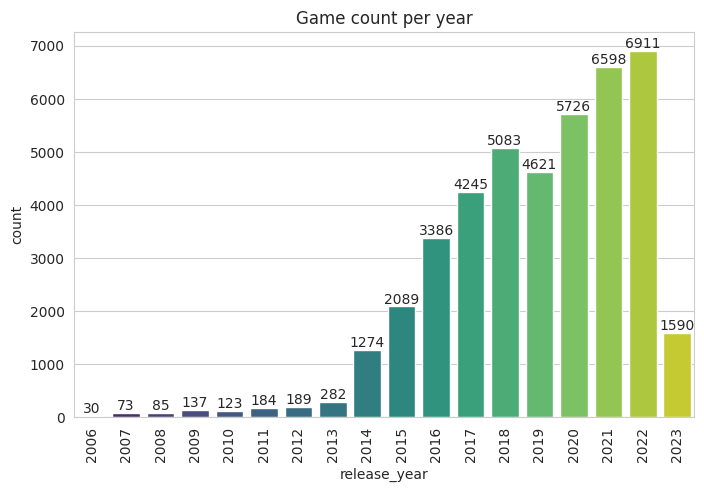

In [193]:
plt.figure(figsize=(8, 5))
plt.title('Game count per year')
ax = sns.countplot(data=df, x='release_year', palette='viridis')
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=90)
plt.show()

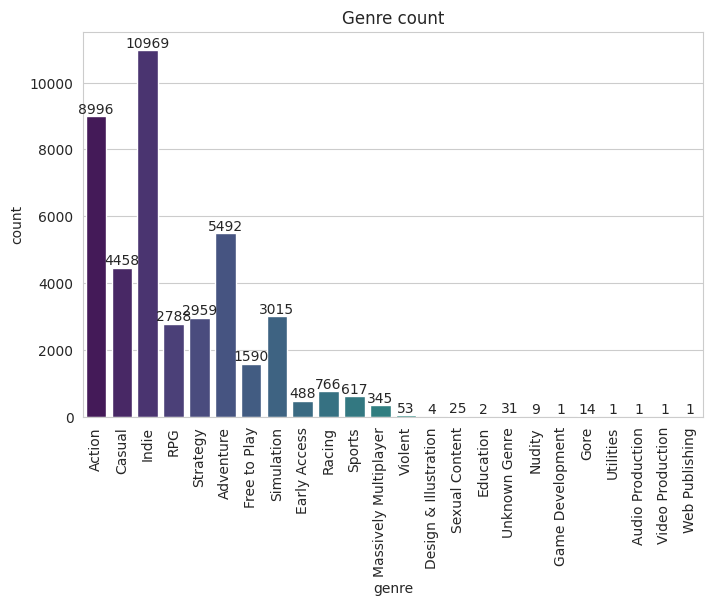

In [245]:
plt.figure(figsize=(8, 5))
plt.title('Genre count')
ax = sns.countplot(data=df, x='genre', palette='viridis')
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=90)
plt.show()

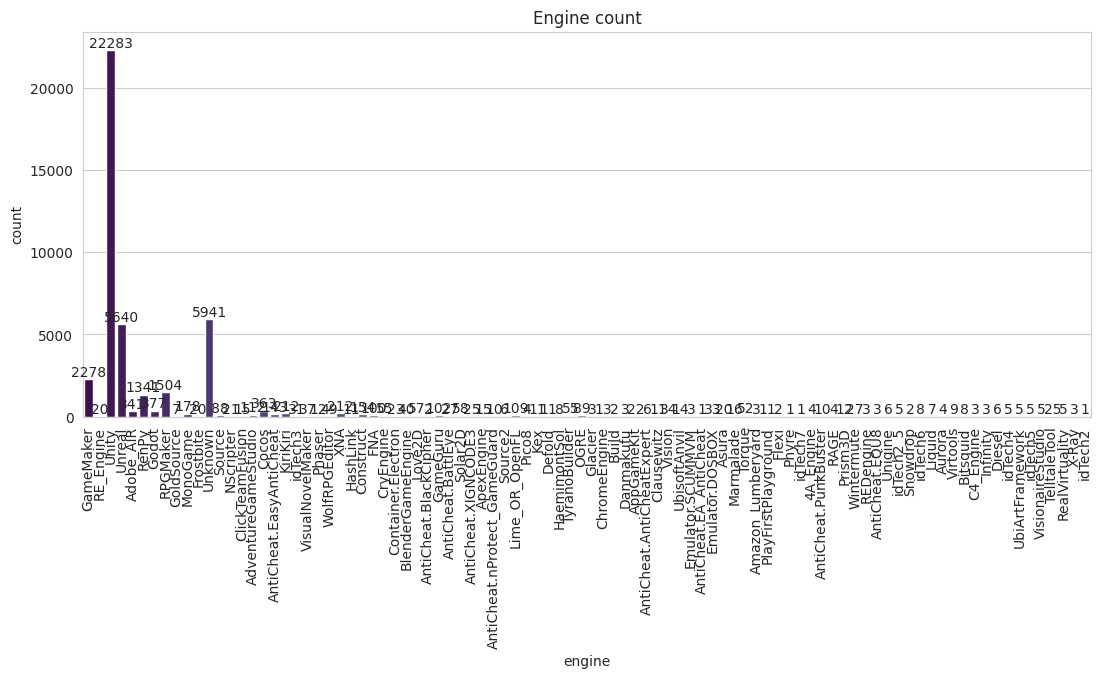

In [249]:
plt.figure(figsize=(13, 5))
plt.title('Engine count')
ax = sns.countplot(data=df, x='engine', palette='viridis')
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=90)
plt.show()

In [237]:
def plot_num(df, columns):
    for i, column in enumerate(columns):
        plt.subplot(int(len(columns) / 2) + 1, 2, i + 1)
        sns.histplot(x=column, data=df, bins=30, kde=True)
        plt.axvline(df[column].mean(), color="r", linestyle="--", label="Mean")
        plt.axvline(df[column].median(), color="g", linestyle="-", label="Median")
        plt.grid()
        plt.title(f"{column} Distribution")
        plt.legend()
        plt.tight_layout()

    plt.show()

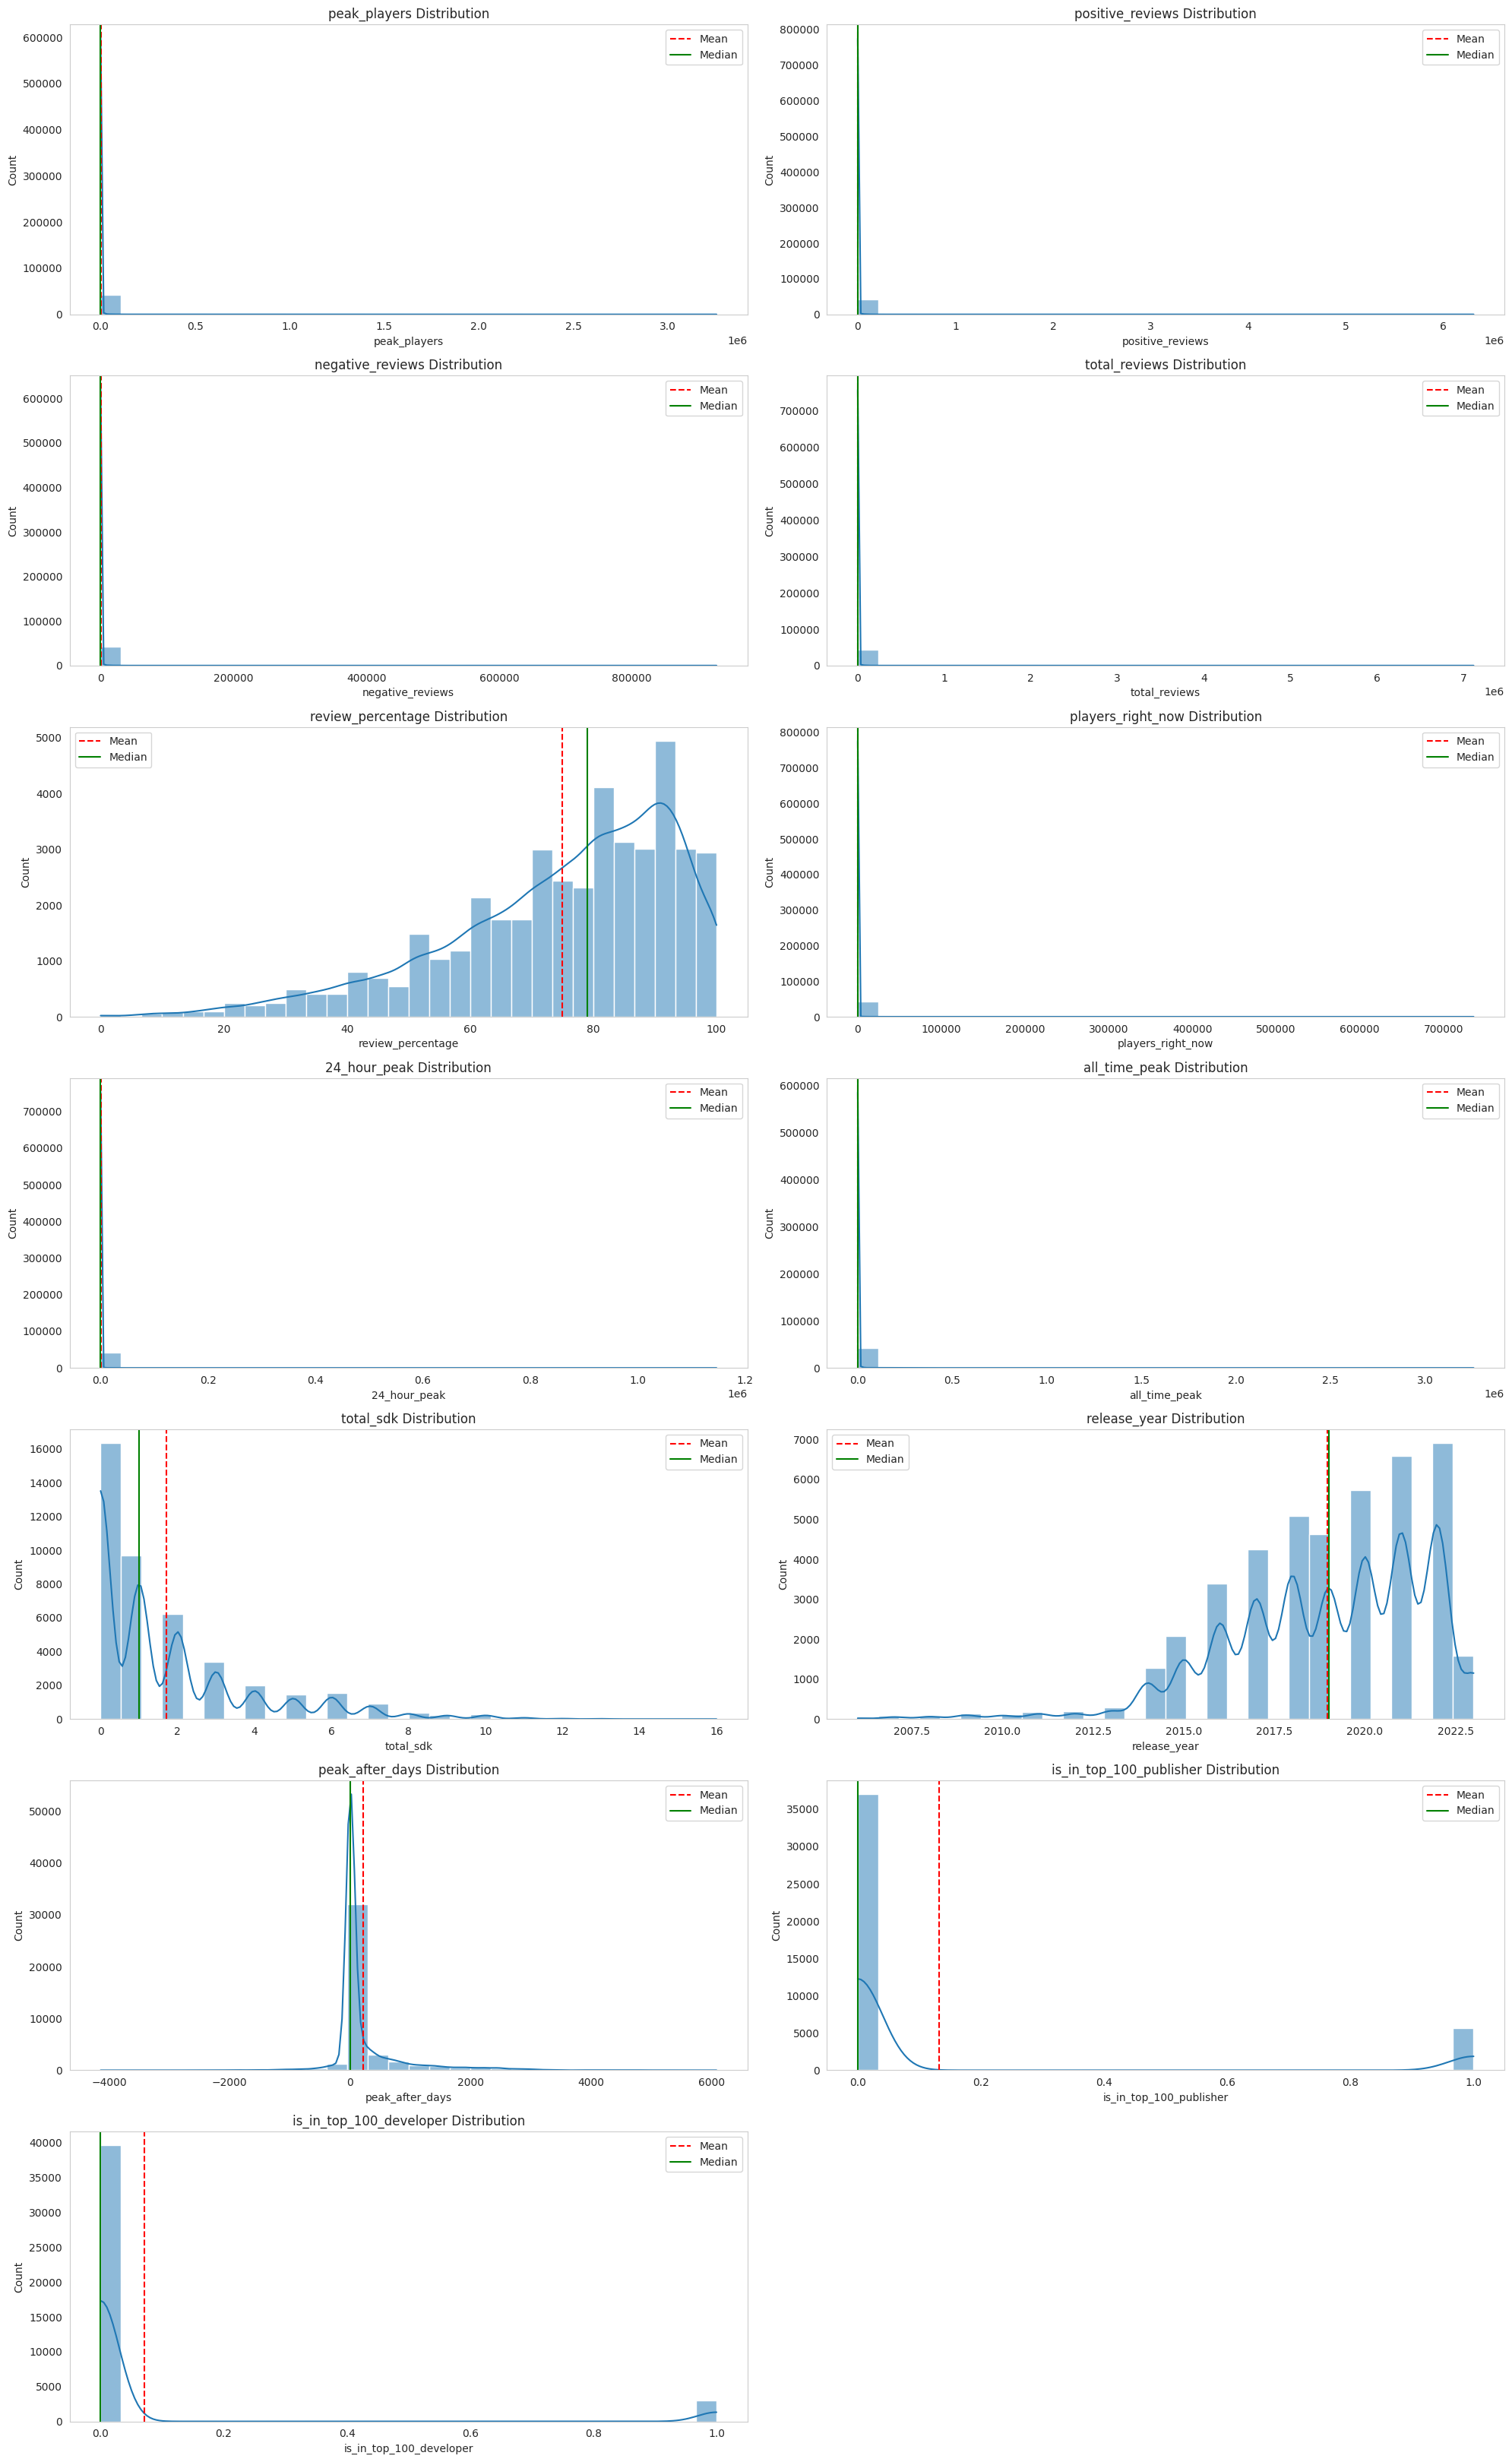

In [199]:
plt.figure(figsize=(20, len(numerical_variables) * 2.5))
plot_num(df, numerical_variables)

# Feature Scaling

In [206]:
df.head()

peak_players  positive_reviews  negative_reviews  total_reviews  rating  \
0          4529             19807               227          20034   96.39   
1        168191             61752              1616          63368   95.75   
2         15543             12643               213          12856   95.54   
3          1415             11717               209          11926   95.39   
4          6132             14152               324          14476   95.09   

   review_percentage  players_right_now  24_hour_peak  all_time_peak  \
0              98.00               3101          3606           4529   
1              97.00              46289         47164         168191   
2              98.00                618           776          15543   
3              98.00                101           101           1415   
4              97.00                630           664           6132   

      engine  total_sdk  release_year  peak_after_days  \
0  GameMaker          1          2023               58   
1  RE_Engine          1          2023                1   
2      Unity          2          2023                0   
3      Unity          1          2023                0   
4     Unreal         11          2023                4   

   is_in_top_100_publisher  is_in_top_100_developer   genre  
0                        0                        0  Action  
1                        0                        1  Action  
2                        1                        0  Casual  
3                        0                        0   Indie  
4                        1                        0  Action

In [207]:
def list_uniq(df, columns):
    for column in columns:
        print(f" {column} ".center(30, "#"))
        for i, val in enumerate(df[column].unique()):
            print(f"{i+1}. {val}")

        print()

In [208]:
list_uniq(df, categorical_variables)

########### engine ###########
1. GameMaker
2. RE_Engine
3. Unity
4. Unreal
5. Adobe_AIR
6. RenPy
7. Godot
8. RPGMaker
9. GoldSource
10. MonoGame
11. Frostbite
12. Unknown
13. Source
14. NScripter
15. ClickTeamFusion
16. AdventureGameStudio
17. Cocos
18. AntiCheat.EasyAntiCheat
19. KiriKiri
20. idTech3
21. VisualNovelMaker
22. Phaser
23. WolfRPGEditor
24. XNA
25. HashLink
26. Construct
27. FNA
28. CryEngine
29. Container.Electron
30. BlenderGameEngine
31. Love2D
32. AntiCheat.BlackCipher
33. GameGuru
34. AntiCheat.BattlEye
35. Solar2D
36. AntiCheat.XIGNCODE3
37. ApexEngine
38. AntiCheat.nProtect_GameGuard
39. Source2
40. Lime_OR_OpenFL
41. Pico8
42. Kex
43. Defold
44. HaemimontSol
45. TyranoBuilder
46. OGRE
47. Glacier
48. ChromeEngine
49. Build
50. Danmakufu
51. AppGameKit
52. AntiCheat.AntiCheatExpert
53. Clausewitz
54. Vision
55. UbisoftAnvil
56. Emulator.SCUMMVM
57. AntiCheat.EA_AntiCheat
58. Emulator.DOSBOX
59. Asura
60. Marmalade
61. Torque
62. Amazon_Lumberyard
63. PlayFirstPlay

In [209]:
X = df.drop('rating', axis=1)
y = df['rating']

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [250]:
genre_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train['genre'] = genre_encoder.fit_transform(X_train['genre'].values.reshape(-1, 1))[:, 0]
X_test['genre'] = genre_encoder.transform(X_test['genre'].values.reshape(-1, 1))[:, 0]

In [251]:
engine_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train['engine'] = engine_encoder.fit_transform(X_train['engine'].values.reshape(-1, 1))[:, 0]
X_test['engine'] = engine_encoder.transform(X_test['engine'].values.reshape(-1, 1))[:, 0]

In [253]:
rs = RobustScaler()
X_train[numerical_variables] = rs.fit_transform(X_train[numerical_variables])
X_test[numerical_variables] = rs.transform(X_test[numerical_variables])

<IPython.core.display.Javascript object>

# Base Models

In [256]:
def adjusted_r2(r2, n, k):
    return r2 - (k - 1) / (n - k) * (1 - r2)

def root_mse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [266]:
models = {}
models['Random Forest'] = RandomForestRegressor()
models['Gradient Boosting'] = GradientBoostingRegressor()
models['Ada Boost'] = AdaBoostRegressor()
models['Ridge'] = Ridge()
models['Lasso'] = Lasso()
models['Linear Regression'] = LinearRegression()
models['Elastic Net'] = ElasticNet()
models['SVR'] = SVR()
models['Linear SVR'] = LinearSVR()
models['LGBM'] = LGBMRegressor(verbose=0)
models['XGB'] = XGBRegressor()
models['Cat Boost'] = CatBoostRegressor(verbose=0)
models['KNN'] = KNeighborsRegressor()

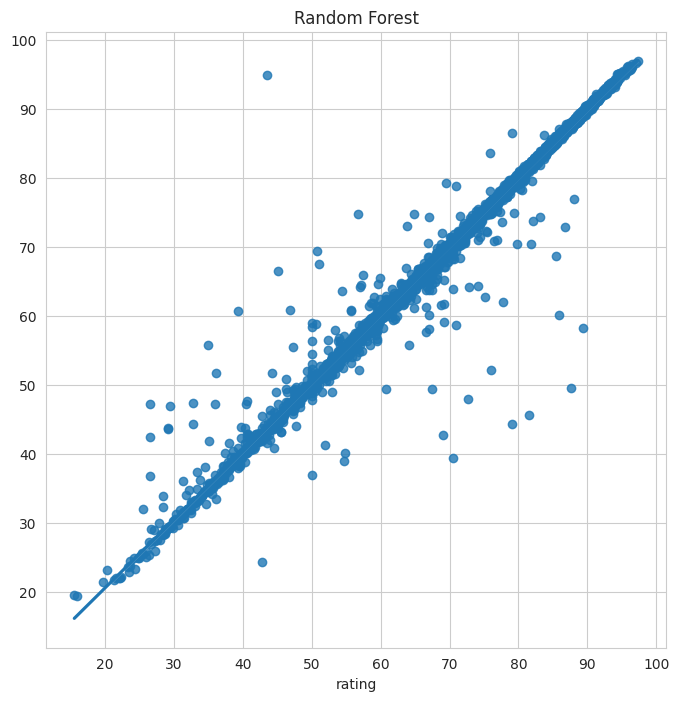

##################################################


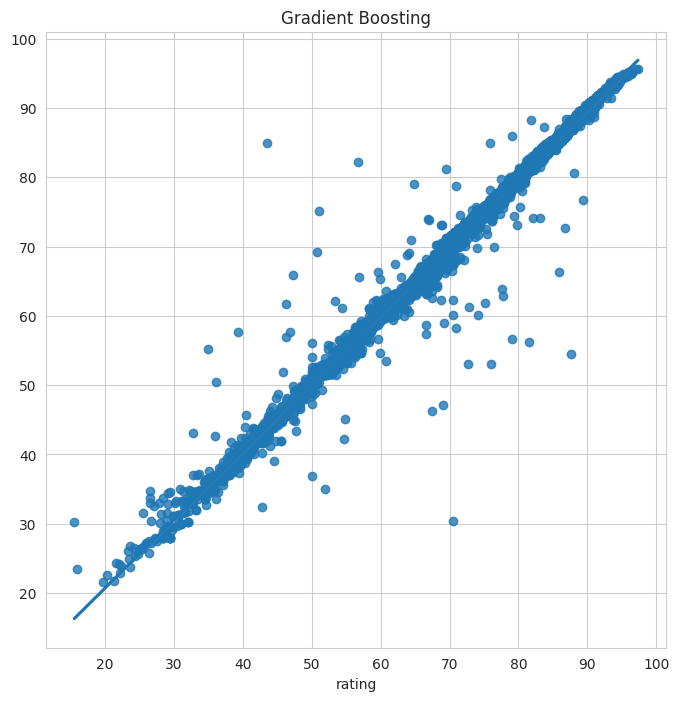

##################################################


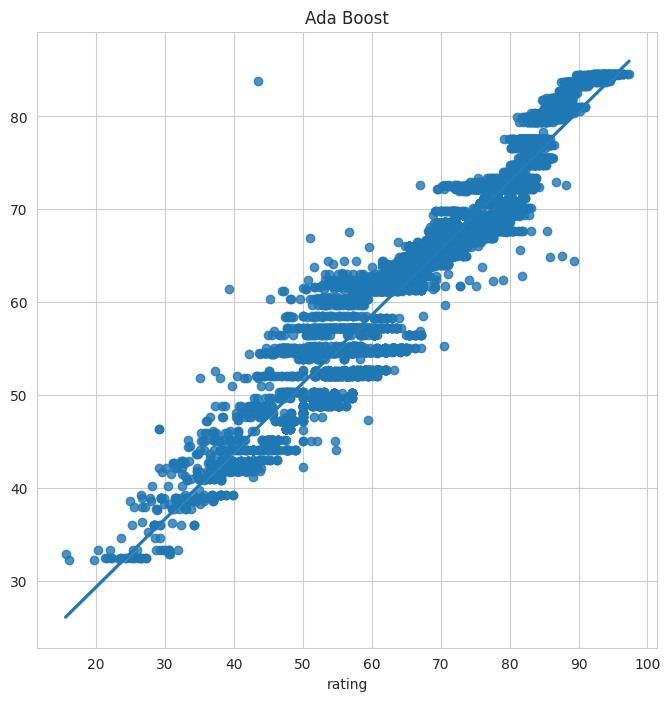

##################################################


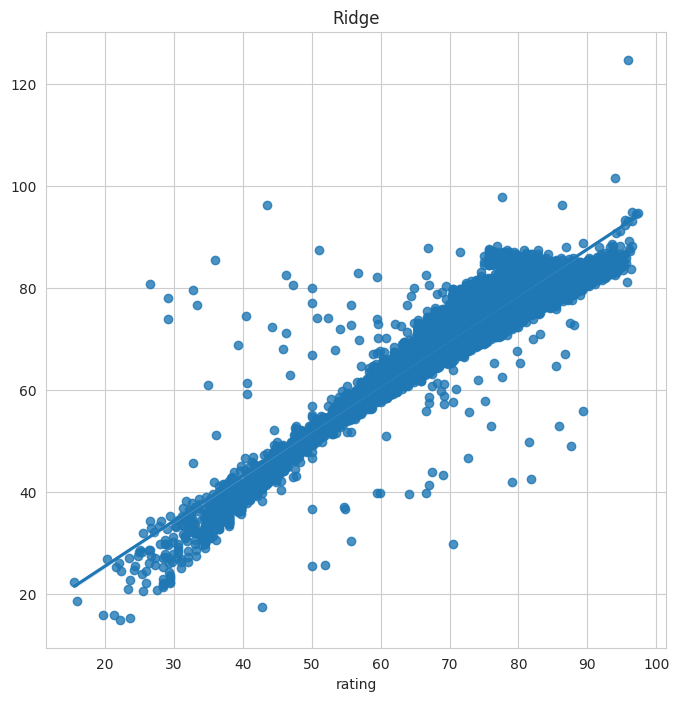

##################################################


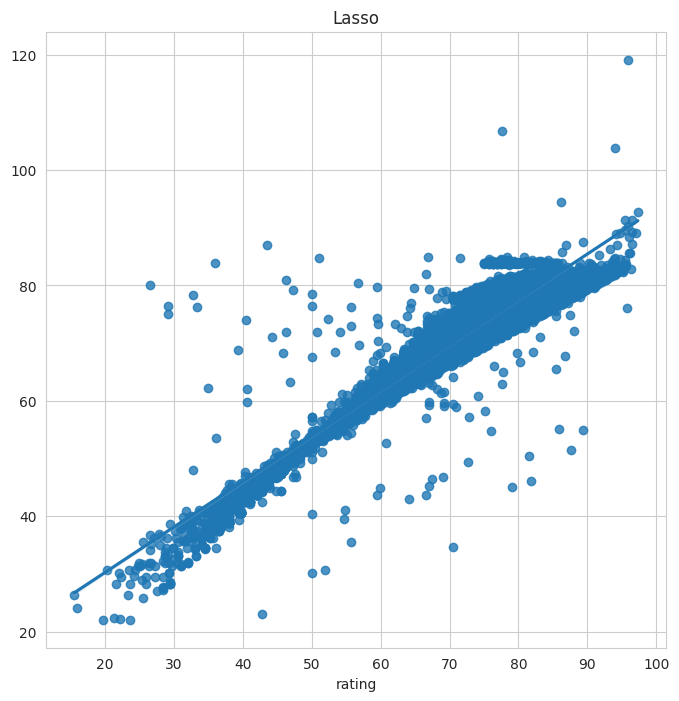

##################################################


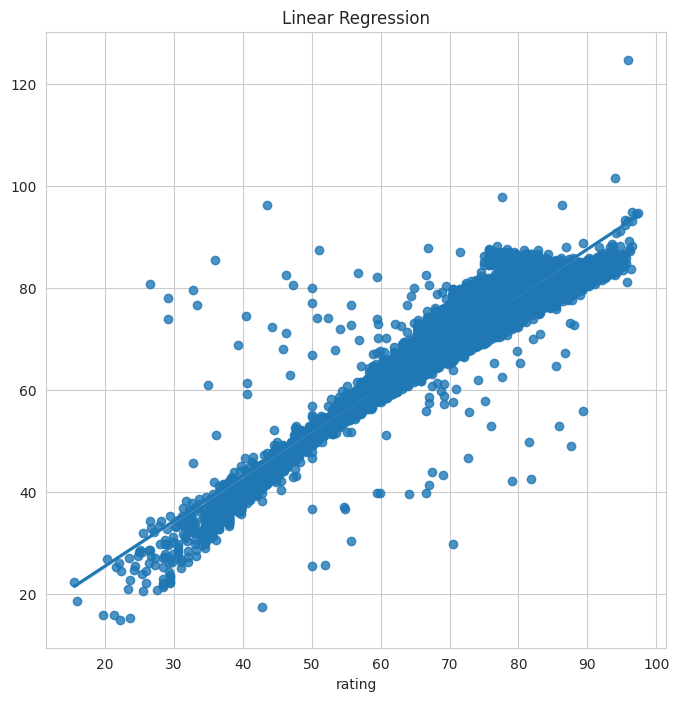

##################################################


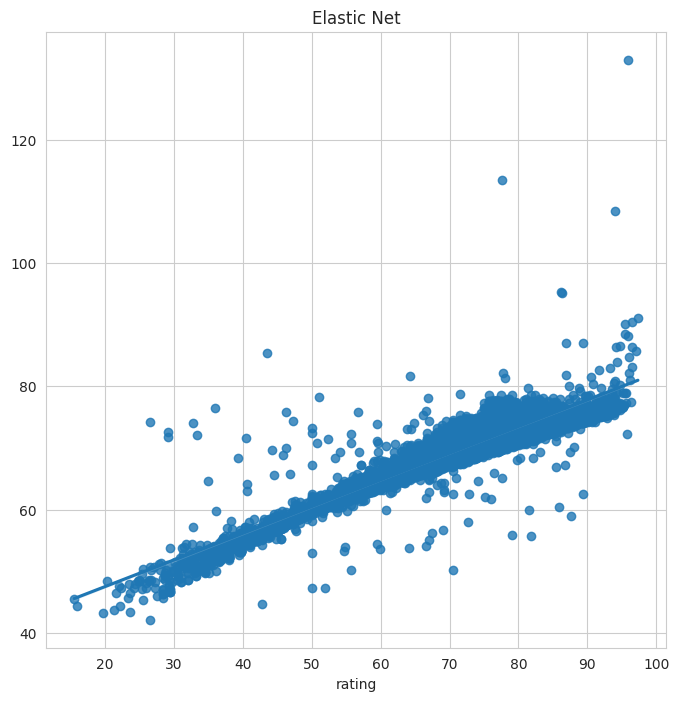

##################################################


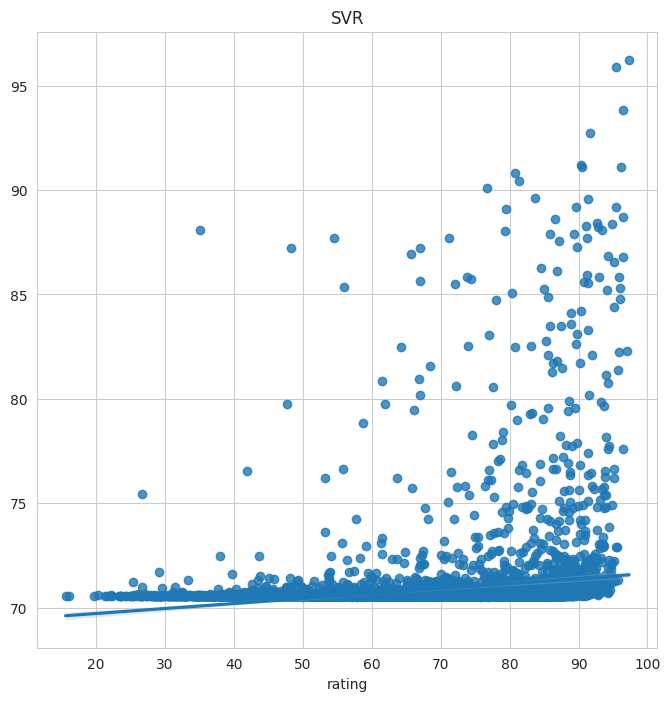

##################################################


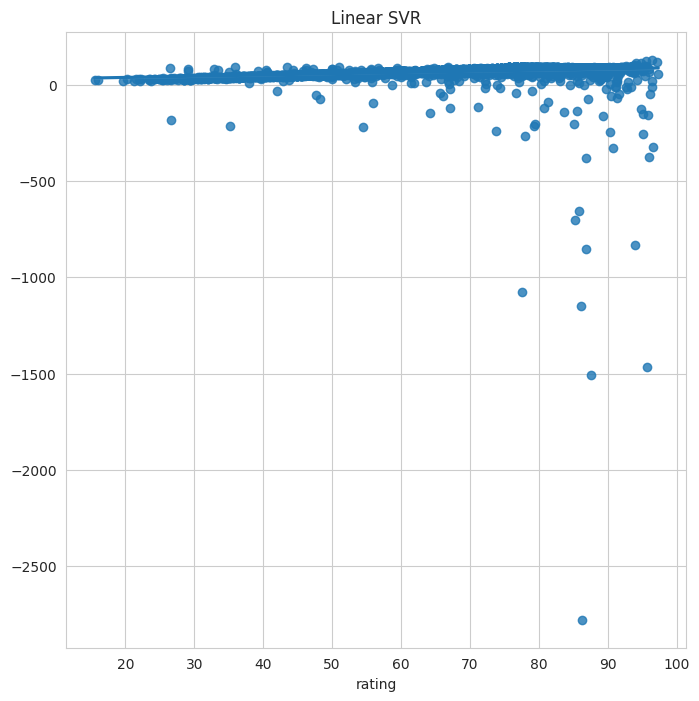

##################################################
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_col_wise=true` to remove the overhead.


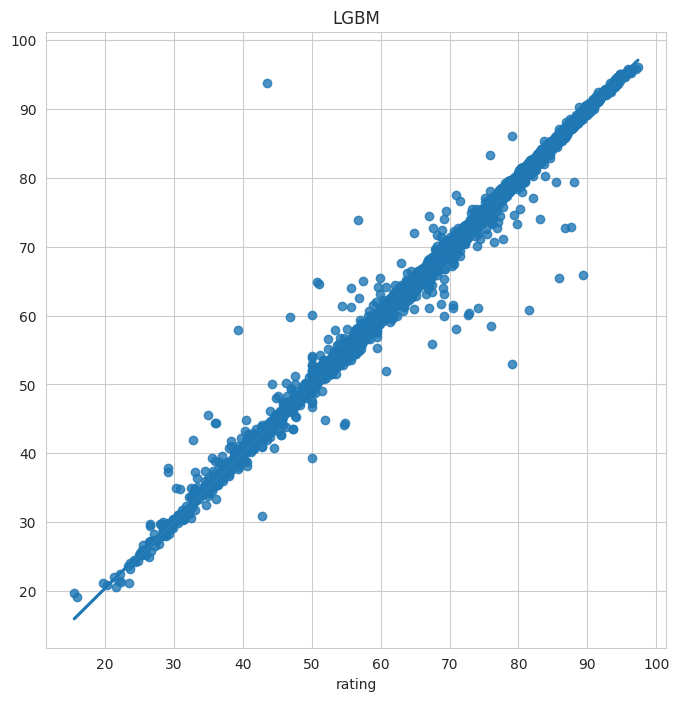

##################################################


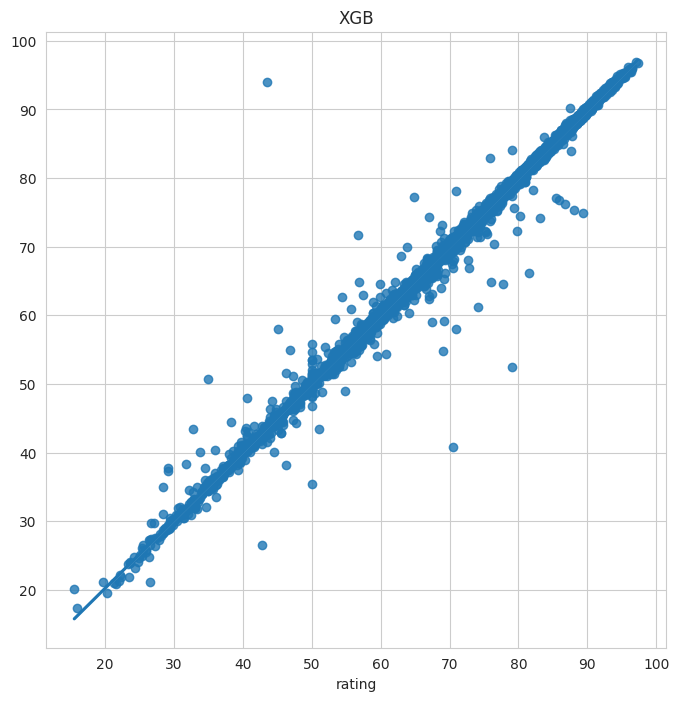

##################################################


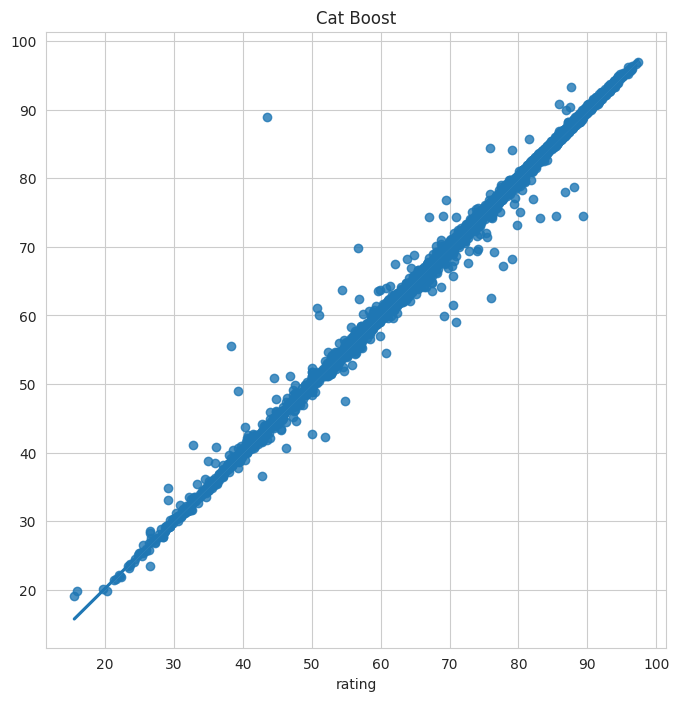

##################################################


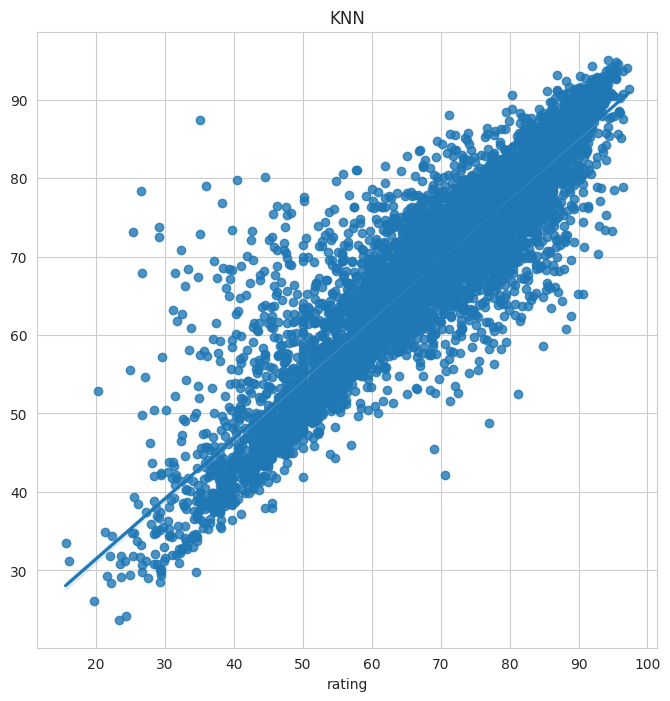

##################################################


In [267]:
train_time, test_time, r2, a_r2, mse, rmse, mae = {}, {}, {}, {}, {}, {}, {}

for key in models.keys():
    start_time = time.time()
    models[key].fit(X_train, y_train)
    end_time = time.time()
    train_time[key] = end_time - start_time

    start_time = time.time()
    y_pred = models[key].predict(X_test)
    end_time = time.time()
    test_time[key] = end_time - start_time

    r2[key] = r2_score(y_test, y_pred)
    a_r2[key] = adjusted_r2(r2_score(y_test, y_pred), X_train.shape[0], X_train.shape[1])
    mse[key] = mean_squared_error(y_test, y_pred)
    rmse[key] = root_mse(y_test, y_pred)
    mae[key] = mean_absolute_error(y_test, y_pred)

    #pkl_filename = f"models/{key}.pkl"
    #with open(pkl_filename, "wb") as file:
    #    pickle.dump(models[key], file)

    plt.figure(figsize=(8, 8))
    sns.regplot(x=y_test, y=y_pred)
    plt.title(f"{key}")
    #save_fig(f"{key} Confusion Matrix")
    plt.show()
    
    print("#" * 50)

# Base Results

In [270]:
base_results_df = pd.DataFrame({"Train Time": train_time.values(),
                           "Test Time": test_time.values(),
                           "R2": r2.values(),
                           "Adjusted R2": a_r2.values(),
                           "MSE": mse.values(),
                           "RMSE": rmse.values(),
                           "MAE": mae.values()}, index=list(models.keys()))

base_results_df

Train Time  Test Time     R2  Adjusted R2     MSE  RMSE  \
Random Forest           14.44       0.15   0.99         0.99    2.69  1.64   
Gradient Boosting        4.61       0.01   0.99         0.99    2.31  1.52   
Ada Boost                2.12       0.03   0.81         0.81   35.30  5.94   
Ridge                    0.00       0.00   0.89         0.89   21.42  4.63   
Lasso                    0.20       0.01   0.87         0.87   24.08  4.91   
Linear Regression        0.01       0.00   0.89         0.89   21.42  4.63   
Elastic Net              0.32       0.01   0.65         0.65   66.21  8.14   
SVR                     63.22      11.10   0.01         0.01  187.54 13.69   
Linear SVR               3.07       0.00 -12.70       -12.71 2583.99 50.83   
LGBM                     0.18       0.01   0.99         0.99    1.47  1.21   
XGB                      0.84       0.01   0.99         0.99    1.27  1.13   
Cat Boost                2.53       0.00   1.00         1.00    0.81  0.90   
KNN                      0.06       1.03   0.81         0.81   34.92  5.91   

                    MAE  
Random Forest      0.36  
Gradient Boosting  0.55  
Ada Boost          5.12  
Ridge              3.19  
Lasso              3.64  
Linear Regression  3.19  
Elastic Net        6.43  
SVR               10.70  
Linear SVR         7.52  
LGBM               0.42  
XGB                0.35  
Cat Boost          0.31  
KNN                3.79

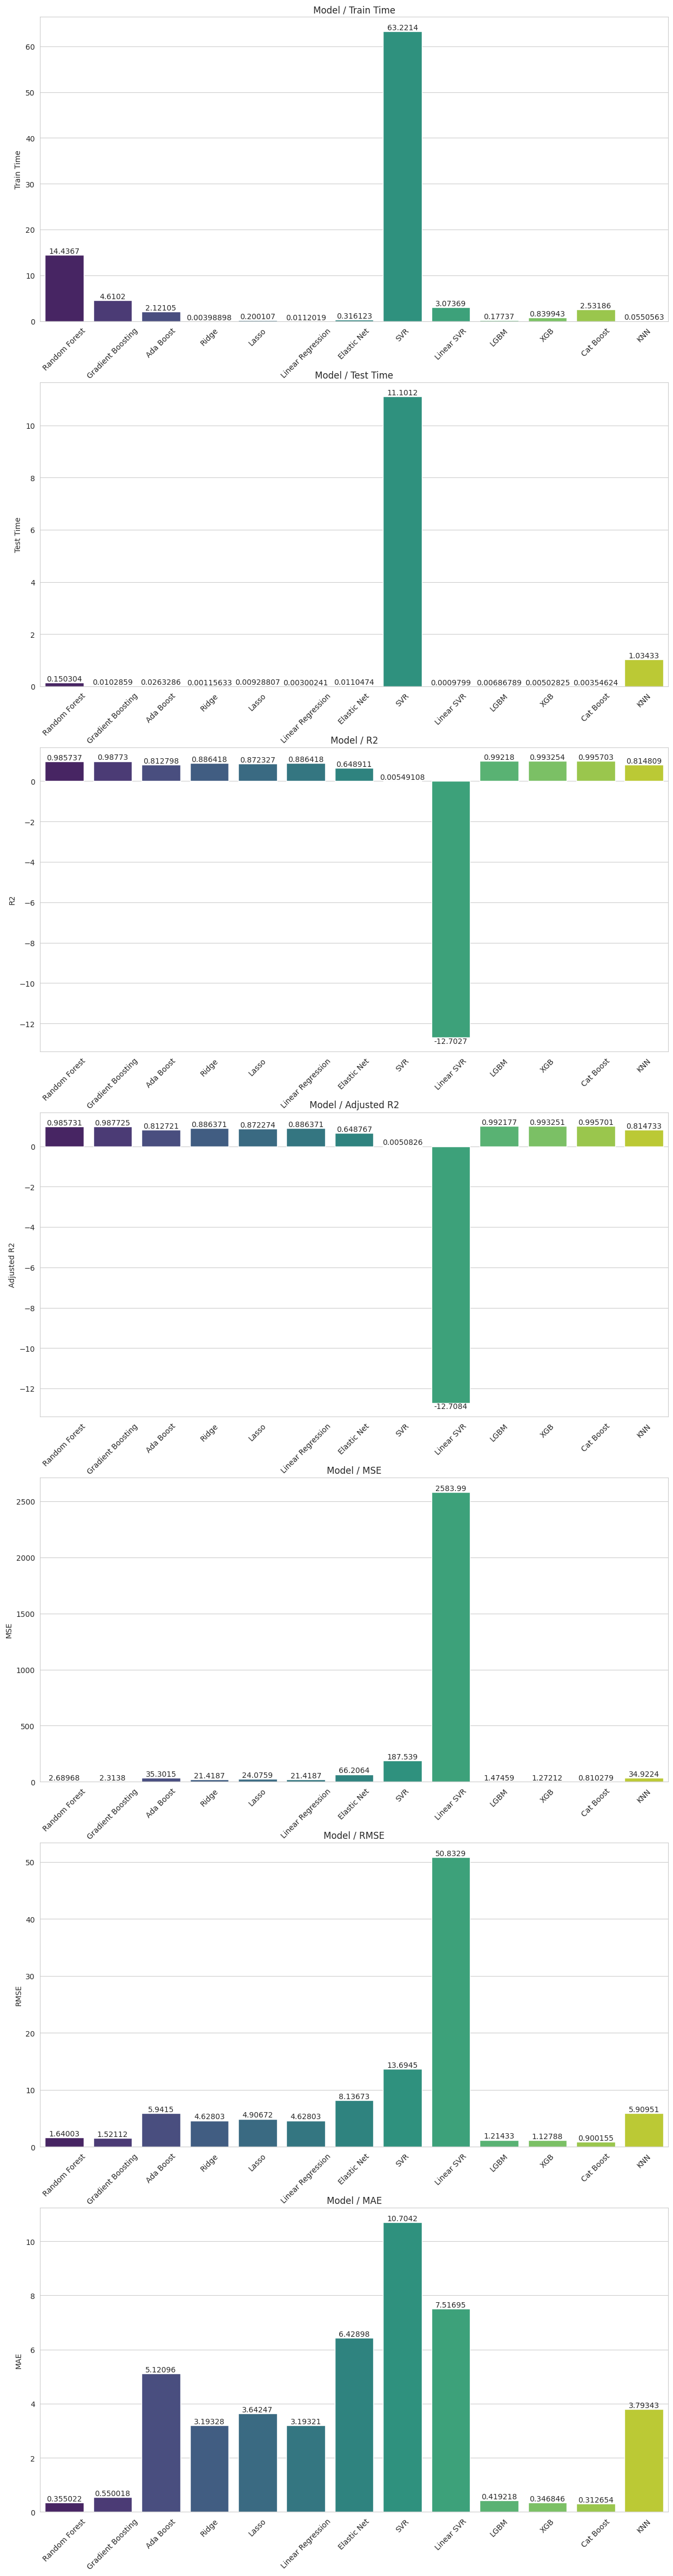

In [287]:
plt.figure(figsize=(15, 60))

plt.subplot(711)
ax = sns.barplot(data=base_results_df, x=base_results_df.index, y="Train Time", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / Train Time")

plt.subplot(712)
ax = sns.barplot(data=base_results_df, x=base_results_df.index, y="Test Time", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / Test Time")

plt.subplot(713)
ax = sns.barplot(data=base_results_df, x=base_results_df.index, y="R2", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / R2")

plt.subplot(714)
ax = sns.barplot(data=base_results_df, x=base_results_df.index, y="Adjusted R2", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / Adjusted R2")

plt.subplot(715)
ax = sns.barplot(data=base_results_df, x=base_results_df.index, y="MSE", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / MSE")

plt.subplot(716)
ax = sns.barplot(data=base_results_df, x=base_results_df.index, y="RMSE", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / RMSE")

plt.subplot(717)
ax = sns.barplot(data=base_results_df, x=base_results_df.index, y="MAE", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / MAE")

plt.show()

# Feature Selection

In [288]:
def plot_correlation_table(df):
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 20))
    mask = np.triu(np.ones_like(corr))
    sns.heatmap(corr, mask=mask, linewidth=0.6, annot=True, robust=True, center=0, square=True)
    plt.title("Correlation Table")
    plt.show()

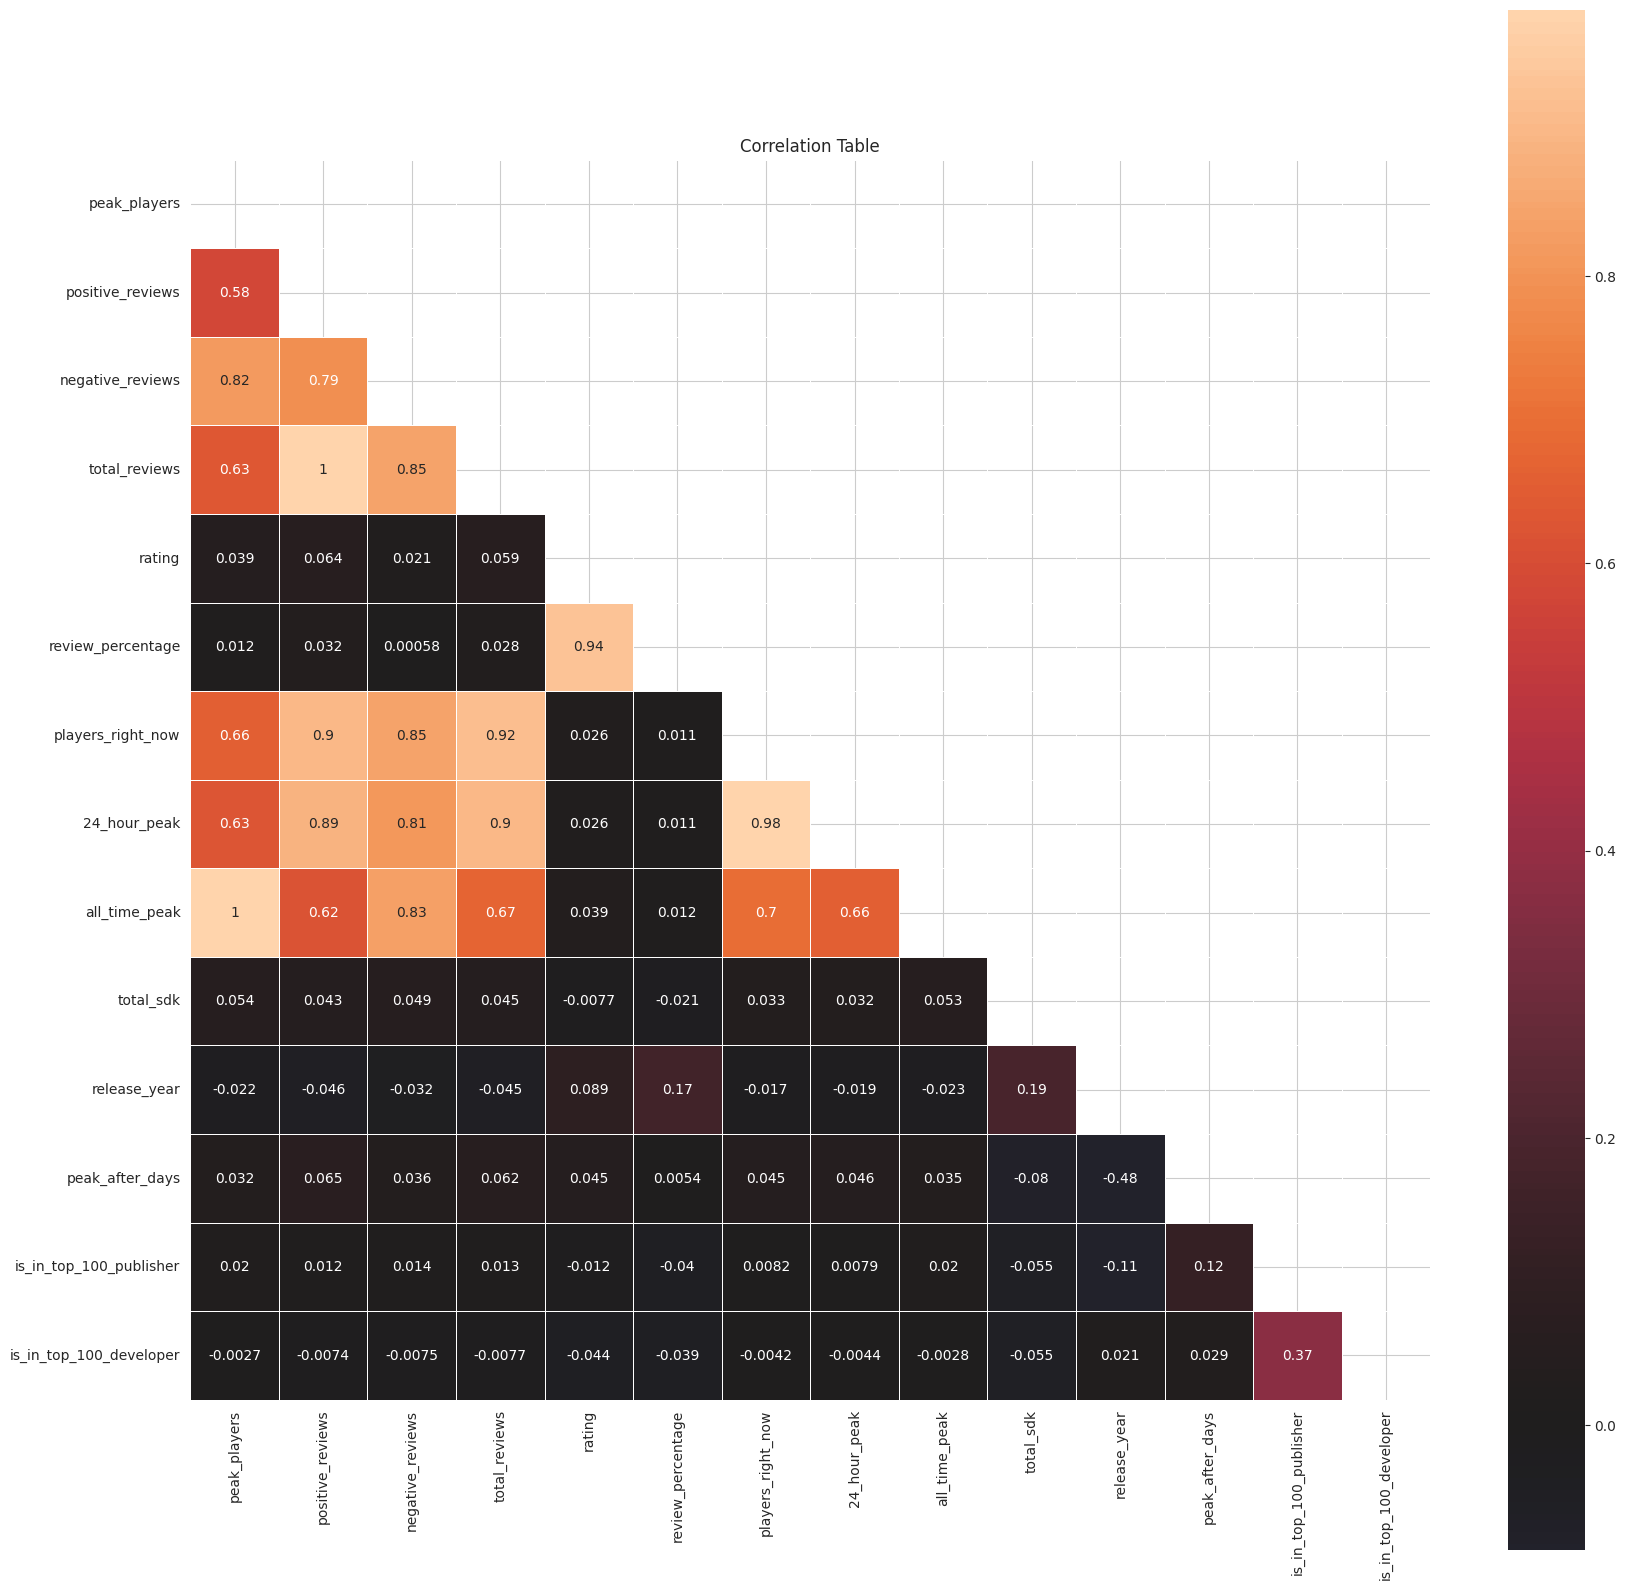

In [289]:
plot_correlation_table(df)

In [290]:
f_value = f_regression(X_train, y_train)

for feature in zip(X_train.columns, f_value[0]):
    print(feature)

('peak_players', 43.34190918857362)
('positive_reviews', 120.12823620351759)
('negative_reviews', 14.640776509437725)
('total_reviews', 102.45814179435091)
('review_percentage', 255677.41475006877)
('players_right_now', 21.503285580882682)
('24_hour_peak', 20.224095016693575)
('all_time_peak', 42.34654948204044)
('engine', 157.56119682210843)
('total_sdk', 2.5858220353210717)
('release_year', 299.01731005329145)
('peak_after_days', 59.91893436708154)
('is_in_top_100_publisher', 10.463452963672822)
('is_in_top_100_developer', 76.33203464352742)
('genre', 33.89734236952108)


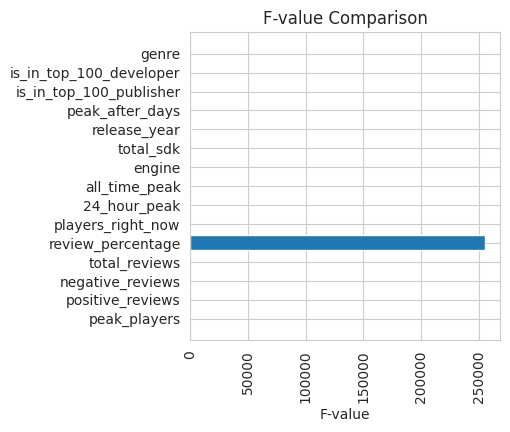

In [291]:
plt.figure(figsize=(4, 4))
plt.barh(y=X_train.columns, width=f_value[0])
plt.xticks(rotation="vertical")
plt.xlabel("F-value")
plt.title("F-value Comparison")
plt.show()

In [292]:
MI_score = mutual_info_regression(X_train, y_train, random_state=42)

for feature in zip(X_train.columns, MI_score):
    print(feature)

('peak_players', 0.28209242562754433)
('positive_reviews', 2.3211915581593336)
('negative_reviews', 1.644791923398225)
('total_reviews', 2.3514323382815623)
('review_percentage', 2.515160782690264)
('players_right_now', 0.11846957343777342)
('24_hour_peak', 0.1992650180034543)
('all_time_peak', 0.2641929534904648)
('engine', 0.02429467333595614)
('total_sdk', 0.010041464983097104)
('release_year', 0.05543836804672475)
('peak_after_days', 0.027142626591854402)
('is_in_top_100_publisher', 0.0)
('is_in_top_100_developer', 0.005973007779954687)
('genre', 0.021598567836598193)


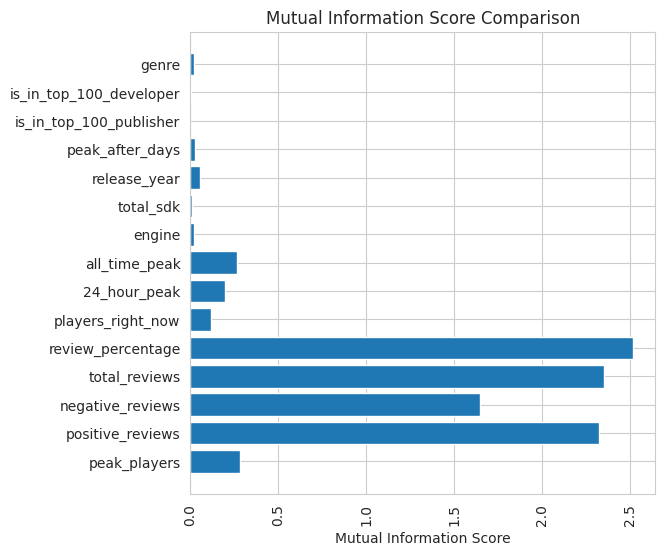

In [295]:
plt.figure(figsize=(6, 6))
plt.barh(y=X_train.columns, width=MI_score)
plt.xticks(rotation="vertical")
plt.yticks(rotation="horizontal")
plt.xlabel("Mutual Information Score")
plt.title("Mutual Information Score Comparison")
plt.show()

In [296]:
skb = SelectKBest(score_func=f_regression, k=5)                  
X_data_new = skb.fit_transform(X_train, y_train)

print('Number of features before feature selection: {}'.format(X_train.shape[1]))
print('Number of features after feature selection: {}'.format(X_data_new.shape[1]))

for feature_list_index in skb.get_support(indices=True):
    print('- ' + X_train.columns[feature_list_index])

Number of features before feature selection: 15
Number of features after feature selection: 5
- positive_reviews
- total_reviews
- review_percentage
- engine
- release_year


In [297]:
X_train_new = X_train[['positive_reviews', 'total_reviews', 'review_percentage', 'engine', 'release_year']]
X_test_new = X_test[['positive_reviews', 'total_reviews', 'review_percentage', 'engine', 'release_year']]

# Feature-selected Models

In [298]:
f_models = {}
f_models['Random Forest'] = RandomForestRegressor()
f_models['Gradient Boosting'] = GradientBoostingRegressor()
f_models['Ada Boost'] = AdaBoostRegressor()
f_models['Ridge'] = Ridge()
f_models['Lasso'] = Lasso()
f_models['Linear Regression'] = LinearRegression()
f_models['Elastic Net'] = ElasticNet()
f_models['SVR'] = SVR()
f_models['Linear SVR'] = LinearSVR()
f_models['LGBM'] = LGBMRegressor(verbose=0)
f_models['XGB'] = XGBRegressor()
f_models['Cat Boost'] = CatBoostRegressor(verbose=0)
f_models['KNN'] = KNeighborsRegressor()

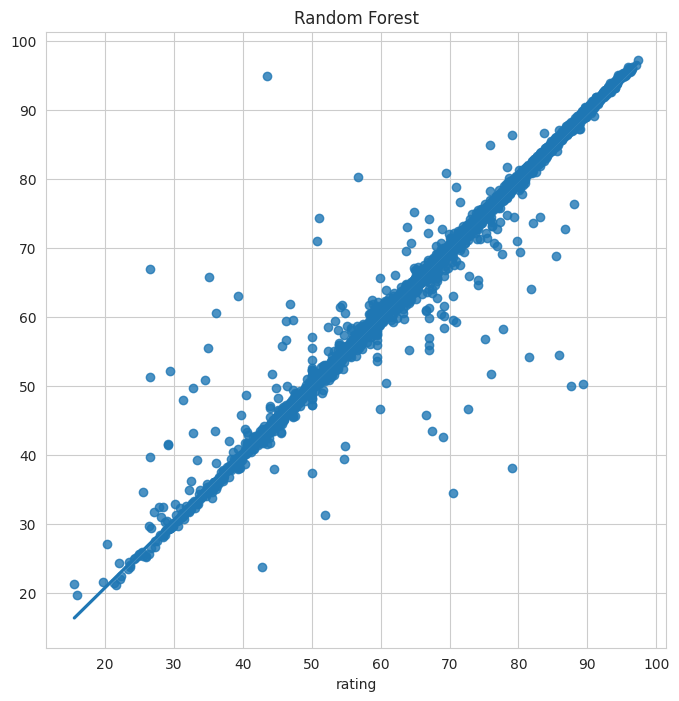

##################################################


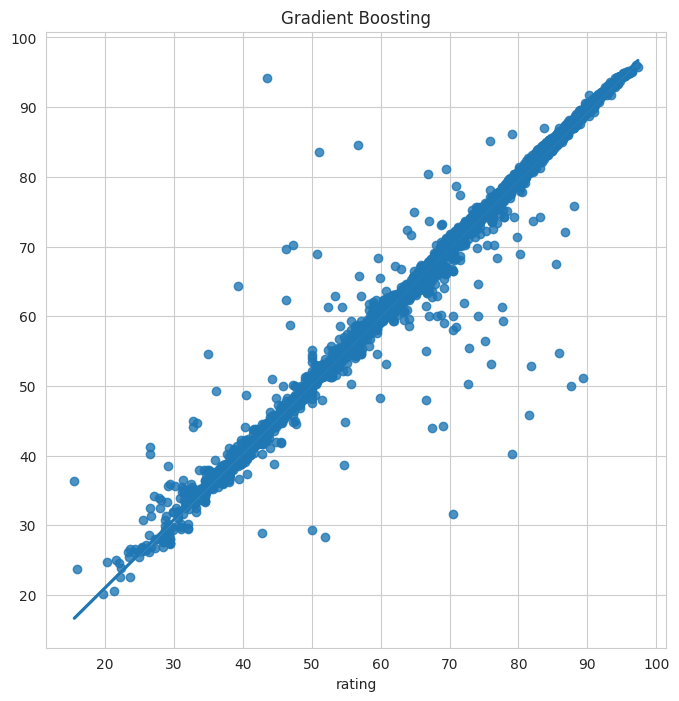

##################################################


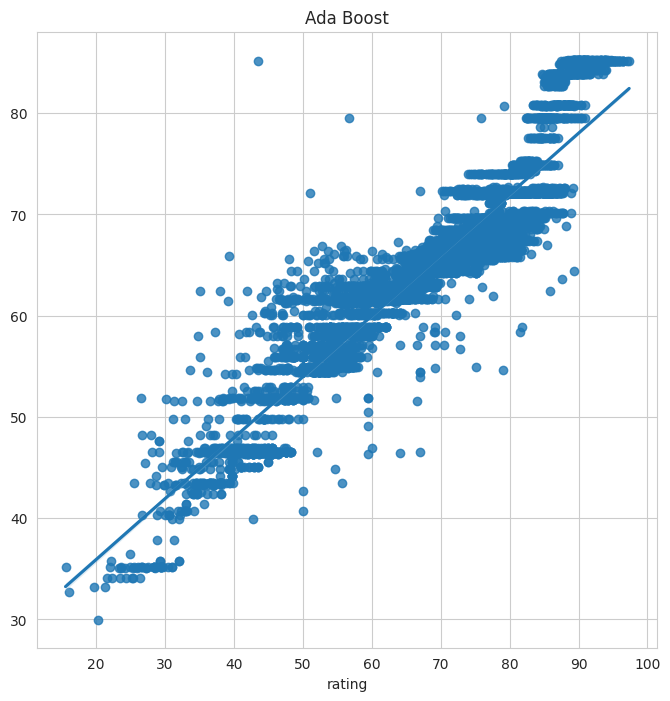

##################################################


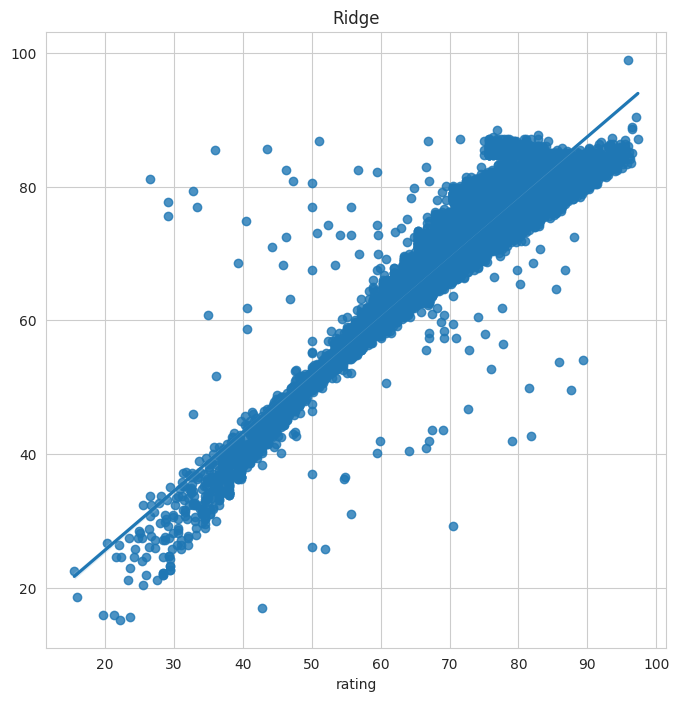

##################################################


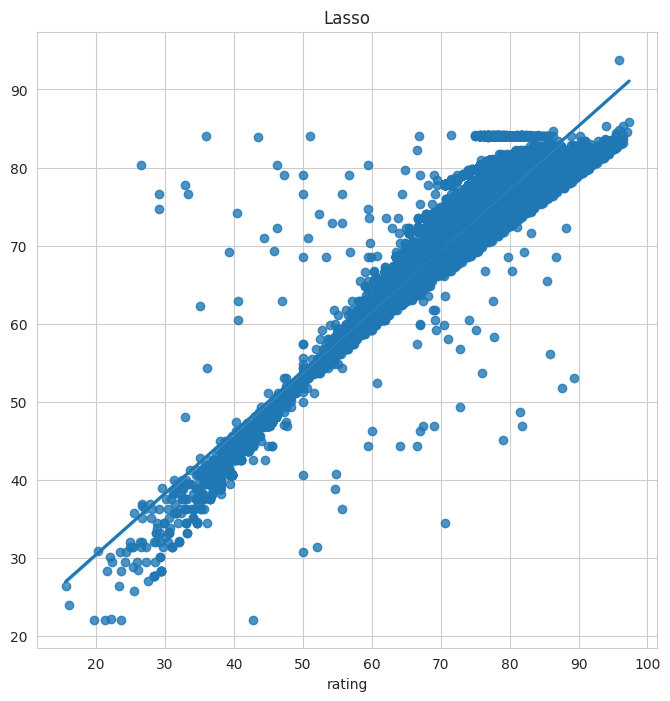

##################################################


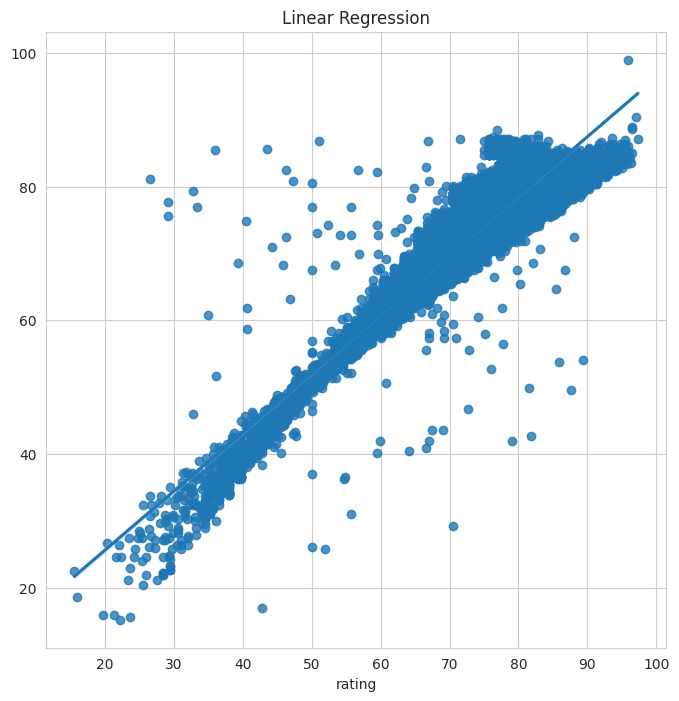

##################################################


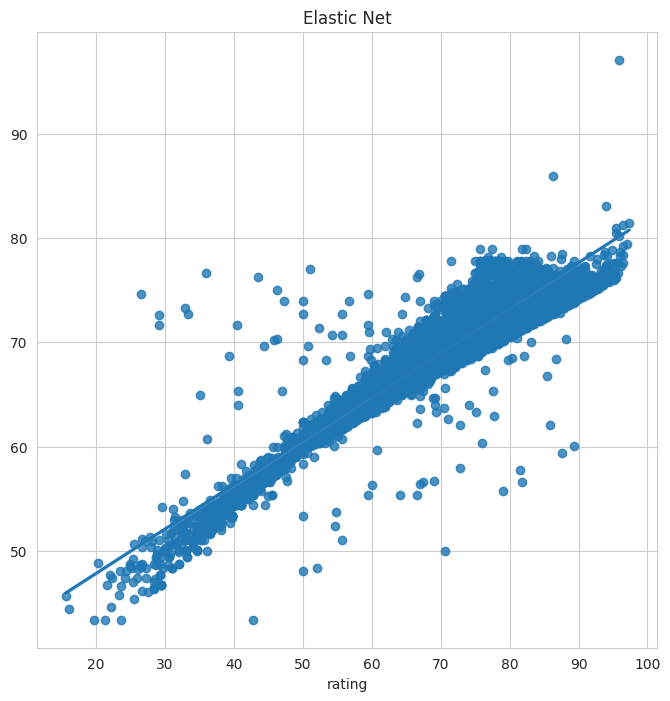

##################################################


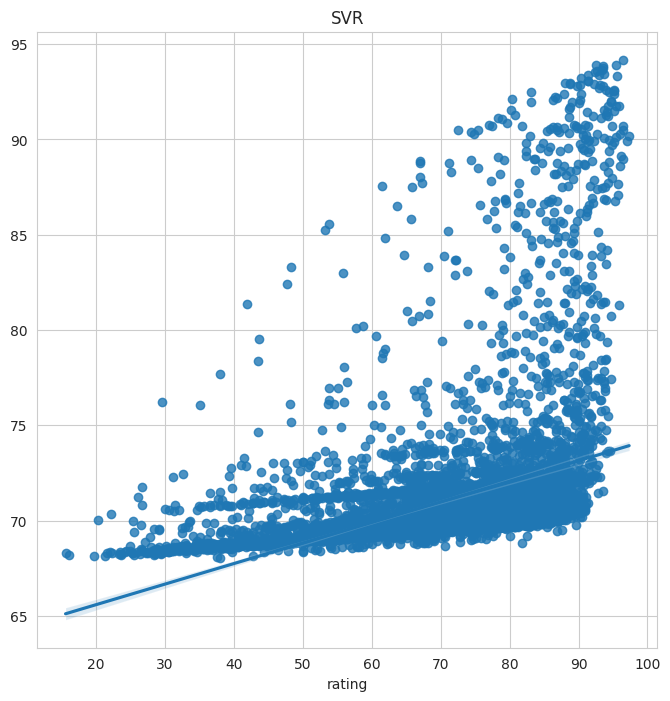

##################################################


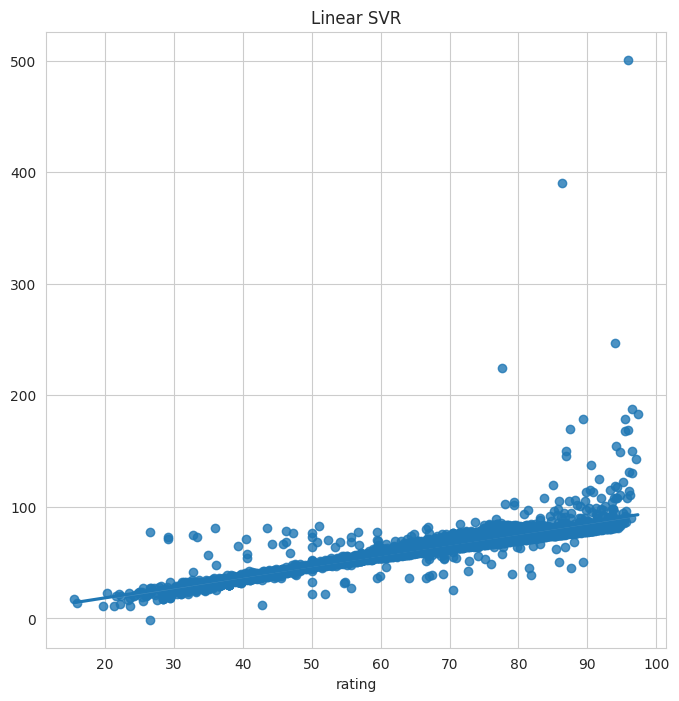

##################################################
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.


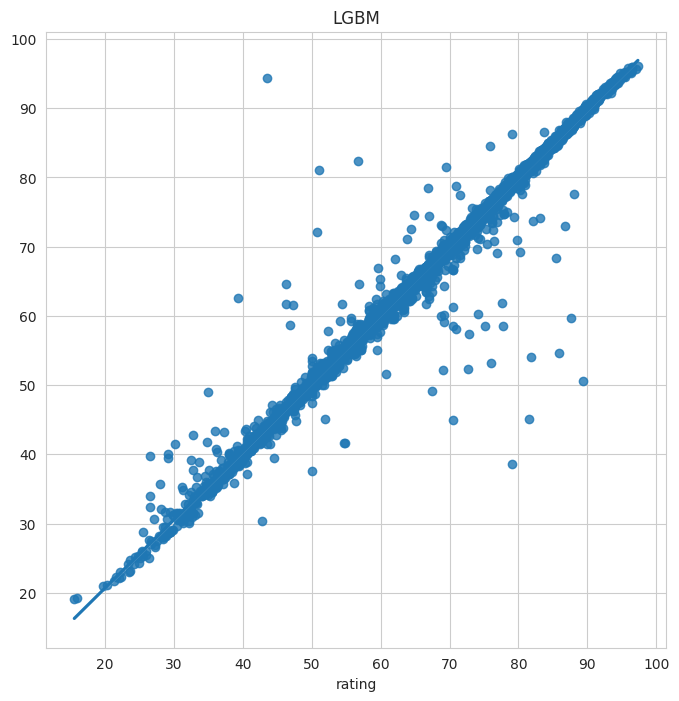

##################################################


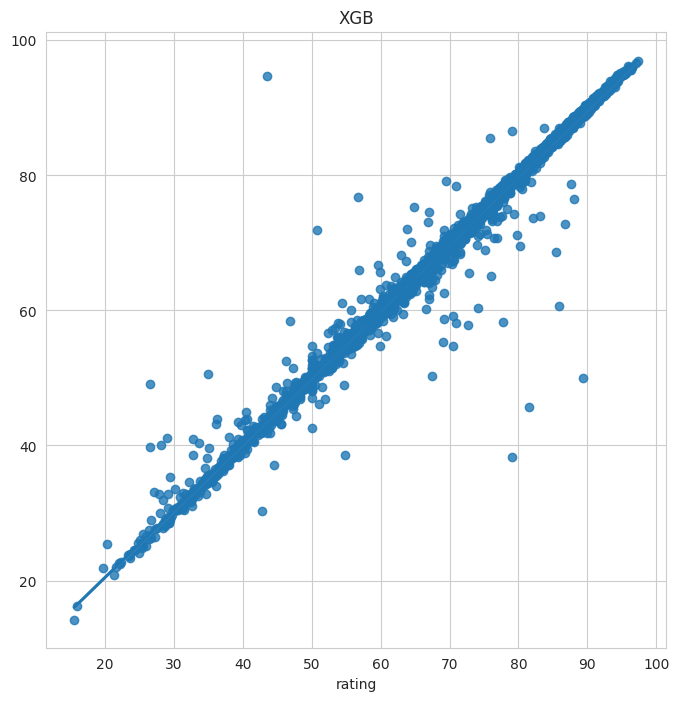

##################################################


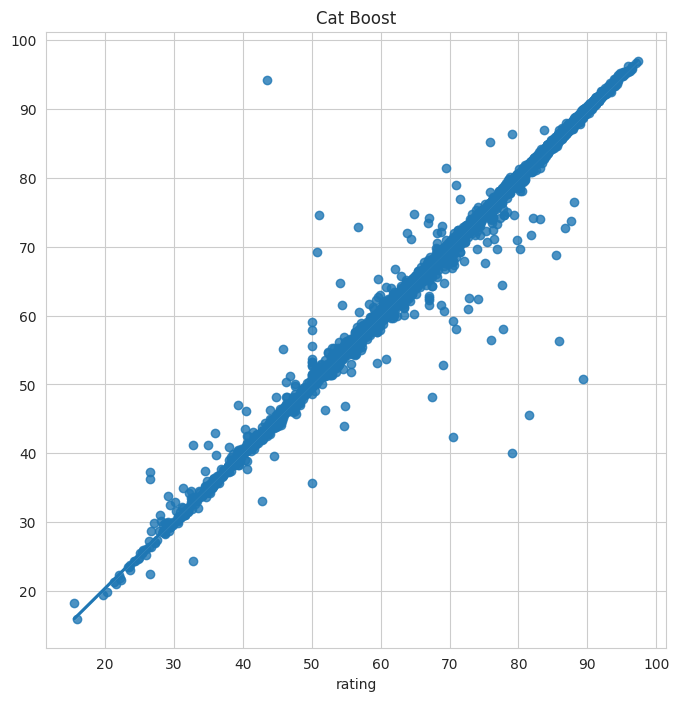

##################################################


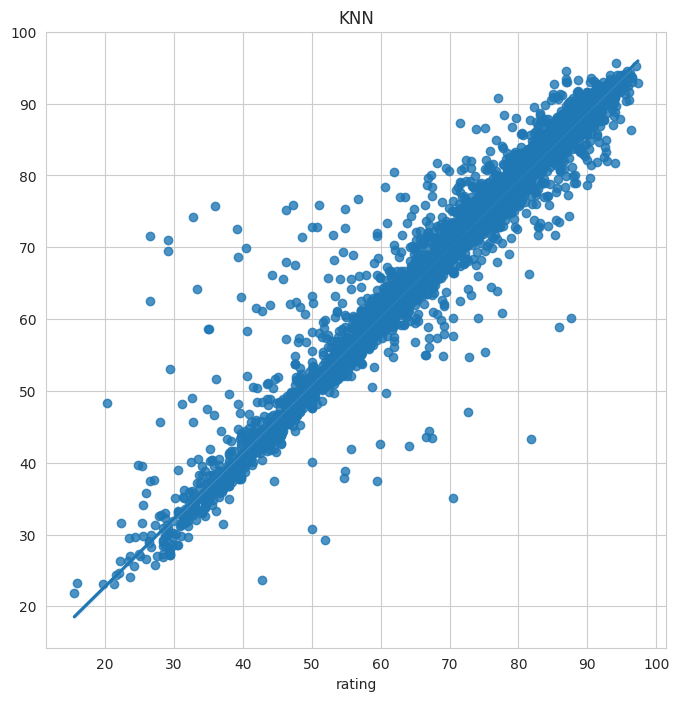

##################################################


In [300]:
f_train_time, f_test_time, f_r2, f_a_r2, f_mse, f_rmse, f_mae = {}, {}, {}, {}, {}, {}, {}

for key in models.keys():
    start_time = time.time()
    f_models[key].fit(X_train_new, y_train)
    end_time = time.time()
    f_train_time[key] = end_time - start_time

    start_time = time.time()
    y_pred = f_models[key].predict(X_test_new)
    end_time = time.time()
    f_test_time[key] = end_time - start_time

    f_r2[key] = r2_score(y_test, y_pred)
    f_a_r2[key] = adjusted_r2(r2_score(y_test, y_pred), X_train_new.shape[0], X_train_new.shape[1])
    f_mse[key] = mean_squared_error(y_test, y_pred)
    f_rmse[key] = root_mse(y_test, y_pred)
    f_mae[key] = mean_absolute_error(y_test, y_pred)

    #pkl_filename = f"models/{key}.pkl"
    #with open(pkl_filename, "wb") as file:
    #    pickle.dump(models[key], file)

    plt.figure(figsize=(8, 8))
    sns.regplot(x=y_test, y=y_pred)
    plt.title(f"{key}")
    #save_fig(f"{key} Confusion Matrix")
    plt.show()
    
    print("#" * 50)

# Feature-Selected Results

In [301]:
f_results_df = pd.DataFrame({"Train Time": f_train_time.values(),
                           "Test Time": f_test_time.values(),
                           "R2": f_r2.values(),
                           "Adjusted R2": f_a_r2.values(),
                           "MSE": f_mse.values(),
                           "RMSE": f_rmse.values(),
                           "MAE": f_mae.values()}, index=list(f_models.keys()))

f_results_df

Train Time  Test Time   R2  Adjusted R2    MSE  RMSE   MAE
Random Forest            5.42       0.15 0.98         0.98   3.64  1.91  0.40
Gradient Boosting        1.93       0.01 0.98         0.98   3.70  1.92  0.61
Ada Boost                0.99       0.02 0.72         0.72  52.50  7.25  6.03
Ridge                    0.00       0.00 0.88         0.88  21.96  4.69  3.25
Lasso                    0.09       0.01 0.87         0.87  24.67  4.97  3.70
Linear Regression        0.00       0.00 0.88         0.88  21.96  4.69  3.25
Elastic Net              0.10       0.00 0.64         0.64  67.05  8.19  6.47
SVR                     45.62       9.59 0.12         0.12 165.86 12.88 10.02
Linear SVR               1.51       0.00 0.58         0.58  78.31  8.85  4.84
LGBM                     0.17       0.01 0.98         0.98   2.83  1.68  0.48
XGB                      0.64       0.01 0.99         0.99   2.06  1.43  0.40
Cat Boost                2.18       0.00 0.99         0.99   2.10  1.45  0.39
KNN                      0.02       0.08 0.96         0.96   8.43  2.90  1.24

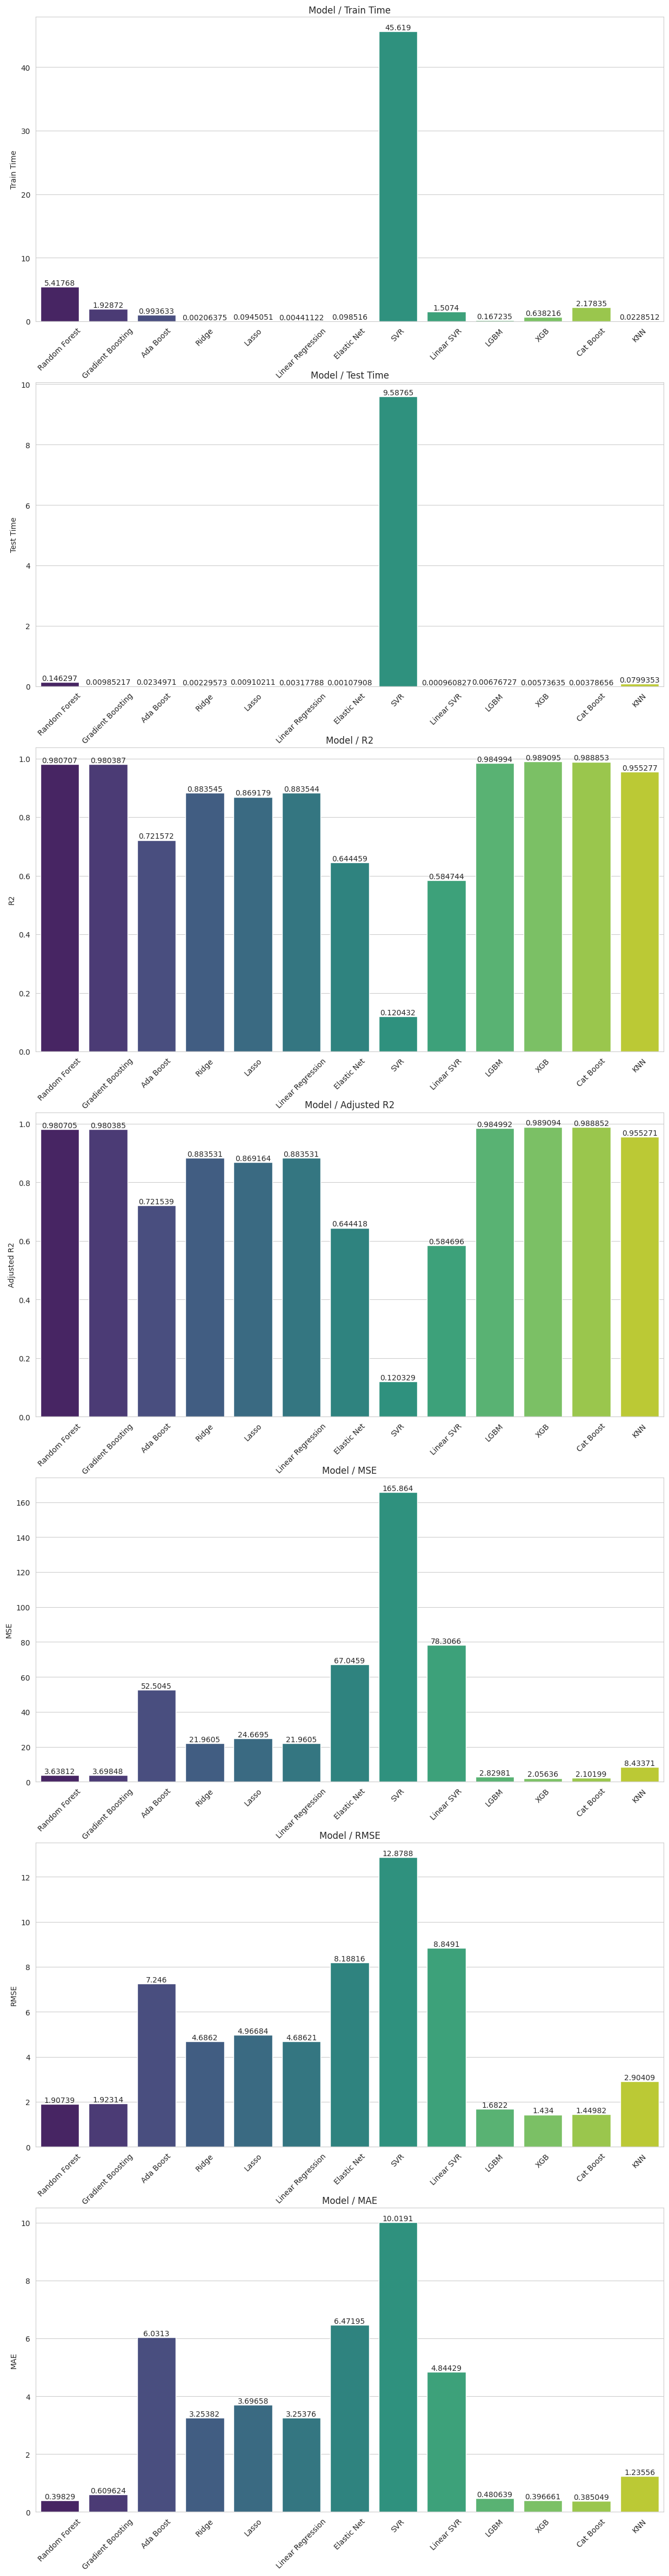

In [302]:
plt.figure(figsize=(15, 60))

plt.subplot(711)
ax = sns.barplot(data=f_results_df, x=f_results_df.index, y="Train Time", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / Train Time")

plt.subplot(712)
ax = sns.barplot(data=f_results_df, x=f_results_df.index, y="Test Time", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / Test Time")

plt.subplot(713)
ax = sns.barplot(data=f_results_df, x=f_results_df.index, y="R2", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / R2")

plt.subplot(714)
ax = sns.barplot(data=f_results_df, x=f_results_df.index, y="Adjusted R2", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / Adjusted R2")

plt.subplot(715)
ax = sns.barplot(data=f_results_df, x=f_results_df.index, y="MSE", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / MSE")

plt.subplot(716)
ax = sns.barplot(data=f_results_df, x=f_results_df.index, y="RMSE", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / RMSE")

plt.subplot(717)
ax = sns.barplot(data=f_results_df, x=f_results_df.index, y="MAE", palette='viridis')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('')
plt.xticks(rotation=45)
plt.title("Model / MAE")

plt.show()

# Hyperparameter Tuning

In [303]:
rf_params = {
    "bootstrap": [True, False],
    "max_depth": [2, 4, 6, 8],
    "max_features": [0.1, 0.2, 0.5],
    "min_samples_split": [0.1, 0.2, 0.5],
    "n_estimators": [50, 100, 250, 500, 1000]
}

rf_model = RandomForestRegressor()

cv = RandomizedSearchCV(rf_model, rf_params, n_iter=10, cv=3, n_jobs=-1, verbose=0)
cv.fit(X_train_new, y_train)

print("Best hyperparams:\n", cv.best_params_)
print("Best score: ", cv.best_score_)

Best hyperparams:
 {'n_estimators': 100, 'min_samples_split': 0.2, 'max_features': 0.5, 'max_depth': 6, 'bootstrap': False}
Best score:  0.8695412495095484


In [304]:
lgbm_params ={
    'learning_rate':[0.01, 0.1, 0.5],
    'n_estimators':[100,500,1000,1250],
    'colsample_bytree': [0.3, 0.7, 1],
    'max_bin':[100, 250, 300],
    'max_depth':[2, 3, 4, 6],
    'min_data_in_leaf':[10, 20, 50],
    'reg_alpha': [1, 2, 5, 10],
    'reg_lambda': [1, 2, 5, 10],
    'min_gain_to_split':[1, 3, 5, 10]
}

lgbm_model = LGBMRegressor()
cv = RandomizedSearchCV(lgbm_model, lgbm_params, n_iter=10, cv=3, n_jobs=-1, verbose=-1)
cv.fit(X_train_new, y_train)

print("Best hyperparams:\n", cv.best_params_)
print("Best score: ", cv.best_score_)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
Best hyperparams:
 {'reg_lambda': 1, 'reg_alpha': 2, 'n_estimators': 500, 'min_gain_to_split': 3, 'min_data_in_leaf': 50, 'max_depth': 6, 'max_bin': 300, 'learning_rate': 0.1, 'colsample_bytree': 1}
Best score:  0.9872749015844766


In [305]:
xgb_params = {
    'n_estimators': [100, 250, 500, 1000],
    'booster':['gbtree', 'gblinear'],
    'learning_rate':[0.01, 0.1, 0.5],
    'max_depth':[2, 3, 5, 7, 10],
    'subsample':[0.5, 0.6, 0.7],
    'min_child_weight': [5, 10, 25],
    'gamma':[5, 10, 25, 50],
    'lambda':[5, 10, 25, 50],
}

xgb_model = XGBRegressor()
cv = RandomizedSearchCV(xgb_model, xgb_params, n_iter=10, cv=3, n_jobs=-1, verbose=0)
cv.fit(X_train_new, y_train)

print("Best hyperparams:\n", cv.best_params_)
print("Best score: ", cv.best_score_)

Best hyperparams:
 {'subsample': 0.5, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.5, 'lambda': 50, 'gamma': 5, 'booster': 'gbtree'}
Best score:  0.9930463646039683


# Comparison

In [307]:
base_results_df

Train Time  Test Time     R2  Adjusted R2     MSE  RMSE  \
Random Forest           14.44       0.15   0.99         0.99    2.69  1.64   
Gradient Boosting        4.61       0.01   0.99         0.99    2.31  1.52   
Ada Boost                2.12       0.03   0.81         0.81   35.30  5.94   
Ridge                    0.00       0.00   0.89         0.89   21.42  4.63   
Lasso                    0.20       0.01   0.87         0.87   24.08  4.91   
Linear Regression        0.01       0.00   0.89         0.89   21.42  4.63   
Elastic Net              0.32       0.01   0.65         0.65   66.21  8.14   
SVR                     63.22      11.10   0.01         0.01  187.54 13.69   
Linear SVR               3.07       0.00 -12.70       -12.71 2583.99 50.83   
LGBM                     0.18       0.01   0.99         0.99    1.47  1.21   
XGB                      0.84       0.01   0.99         0.99    1.27  1.13   
Cat Boost                2.53       0.00   1.00         1.00    0.81  0.90   
KNN                      0.06       1.03   0.81         0.81   34.92  5.91   

                    MAE  
Random Forest      0.36  
Gradient Boosting  0.55  
Ada Boost          5.12  
Ridge              3.19  
Lasso              3.64  
Linear Regression  3.19  
Elastic Net        6.43  
SVR               10.70  
Linear SVR         7.52  
LGBM               0.42  
XGB                0.35  
Cat Boost          0.31  
KNN                3.79

In [308]:
f_results_df

Train Time  Test Time   R2  Adjusted R2    MSE  RMSE   MAE
Random Forest            5.42       0.15 0.98         0.98   3.64  1.91  0.40
Gradient Boosting        1.93       0.01 0.98         0.98   3.70  1.92  0.61
Ada Boost                0.99       0.02 0.72         0.72  52.50  7.25  6.03
Ridge                    0.00       0.00 0.88         0.88  21.96  4.69  3.25
Lasso                    0.09       0.01 0.87         0.87  24.67  4.97  3.70
Linear Regression        0.00       0.00 0.88         0.88  21.96  4.69  3.25
Elastic Net              0.10       0.00 0.64         0.64  67.05  8.19  6.47
SVR                     45.62       9.59 0.12         0.12 165.86 12.88 10.02
Linear SVR               1.51       0.00 0.58         0.58  78.31  8.85  4.84
LGBM                     0.17       0.01 0.98         0.98   2.83  1.68  0.48
XGB                      0.64       0.01 0.99         0.99   2.06  1.43  0.40
Cat Boost                2.18       0.00 0.99         0.99   2.10  1.45  0.39
KNN                      0.02       0.08 0.96         0.96   8.43  2.90  1.24